In [44]:
!pip install yfinance

In [45]:
pwd

'/Users/woorethane/aiffel_quest/mini_quest_240229'

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import warnings
warnings.filterwarnings('ignore')

stock_filepath = os.getenv('HOME') +'/aiffel_quest/mini_quest_240229/data/'
df = pd.read_csv(stock_filepath + '005930.KS.csv')

df.head()

Date     Open     High      Low    Close     Adj Close    Volume
0  2020-05-18  47950.0  49100.0  47600.0  48800.0  46788.835938  20481981
1  2020-05-19  50100.0  50500.0  49700.0  50300.0  48227.015625  25168295
2  2020-05-20  50000.0  50200.0  49800.0  50000.0  47939.382813  14896899
3  2020-05-21  50300.0  50400.0  49850.0  49950.0  47891.437500  14949266
4  2020-05-22  49600.0  49800.0  48600.0  48750.0  46740.894531  19706284

In [47]:
df = pd.read_csv(stock_filepath + '005930.KS.csv', index_col='Date', parse_dates=True)

ts_close =df['Close']
ts_close.head()

Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

### 시계열 안정성 정성적 분석

In [48]:
ts_close = ts_close.interpolate(method='time')
ts_close[ts_close.isna()]

Series([], Name: Close, dtype: float64)

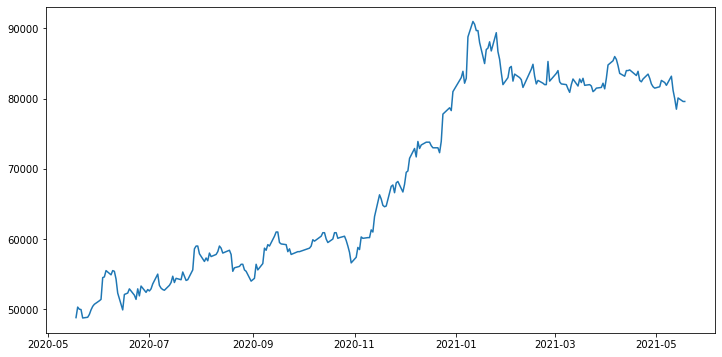

In [49]:
plt.plot(ts_close)

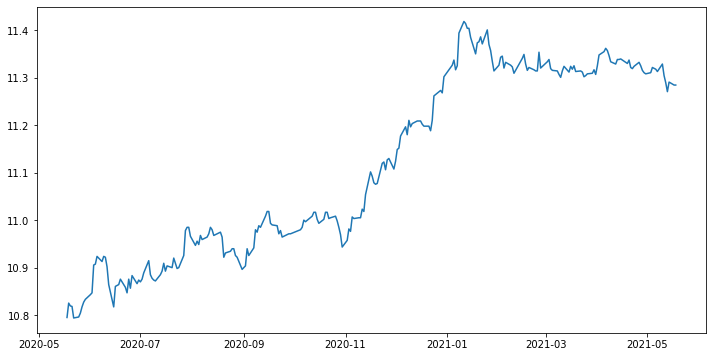

In [50]:
ts_log = np.log(ts_close)
plt.plot(ts_log)

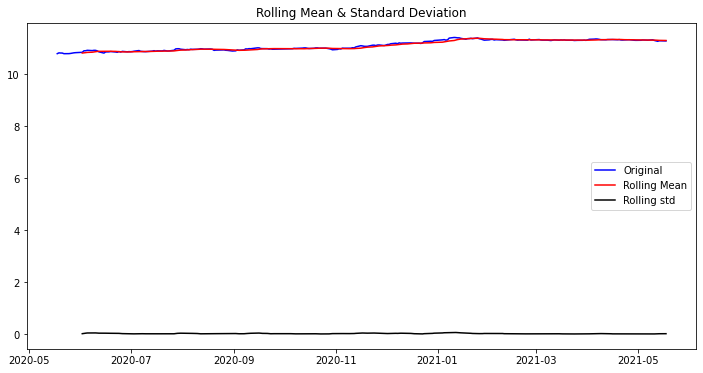

Results of Dickey=Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


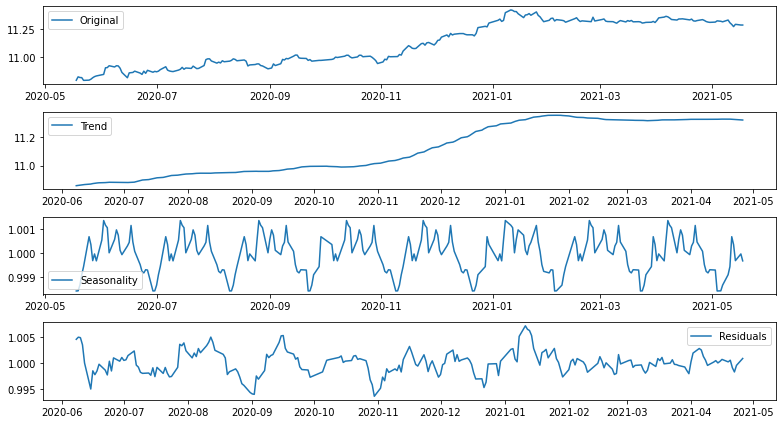

In [51]:
# 정성적 그래프 분석
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()
    rolstd = timeseries.rolling(window=window).std()
    
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)



from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    dftest = adfuller(timeseries, autolag='AIC')
    
    print('Results of Dickey=Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)


#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 


plt.rcParams['figure.figsize'] = (11,6)


trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

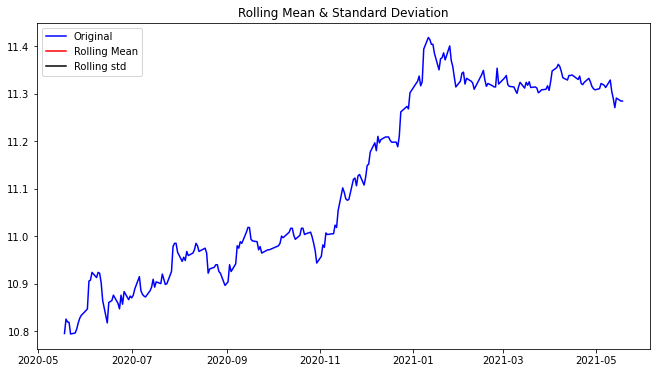

In [52]:
plot_rolling_statistics(ts_log, window=365)

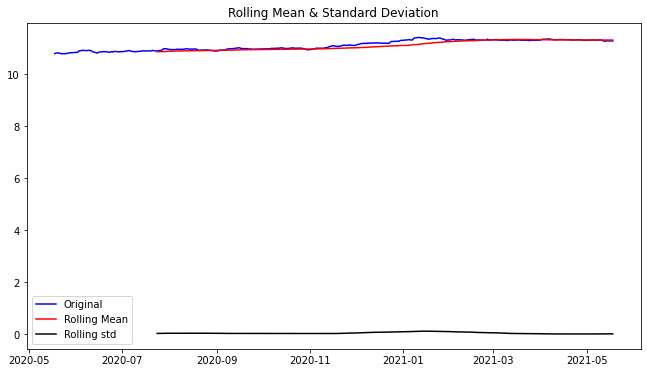

In [53]:
plot_rolling_statistics(ts_log, window=50)

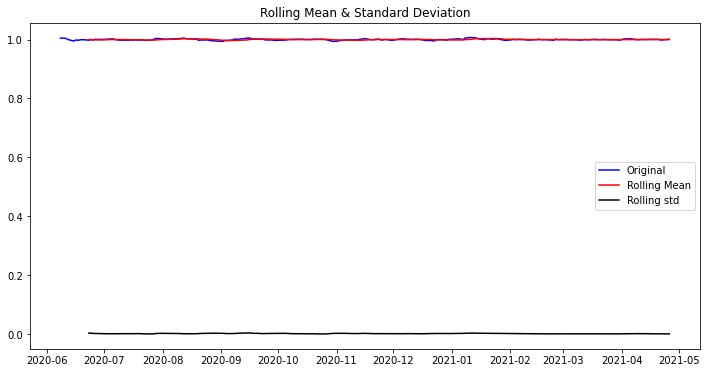

In [54]:
# Residual 안정성 확인
# [[YOUR CODE]]
residual.dropna(inplace=True)
plt.rcParams['figure.figsize'] = (12, 6)
plot_rolling_statistics(residual)

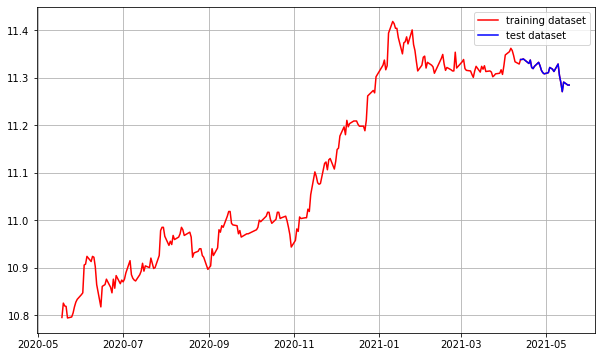

In [55]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]

plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

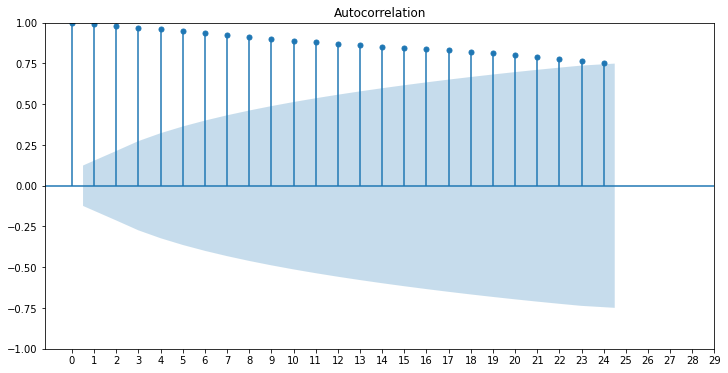

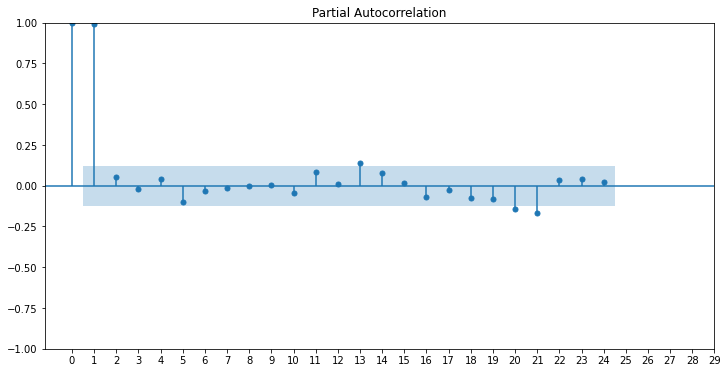

In [56]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


plot_acf(ts_log)
plt.xticks(range(0, 30, 1))
plot_pacf(ts_log)
plt.xticks(range(0, 30, 1))
plt.show()

Results of Dickey=Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64
Results of Dickey=Fuller Test:
Test Statistic                -1.029320e+01
p-value                        3.525823e-18
#Lags Used                     7.000000e+00
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64


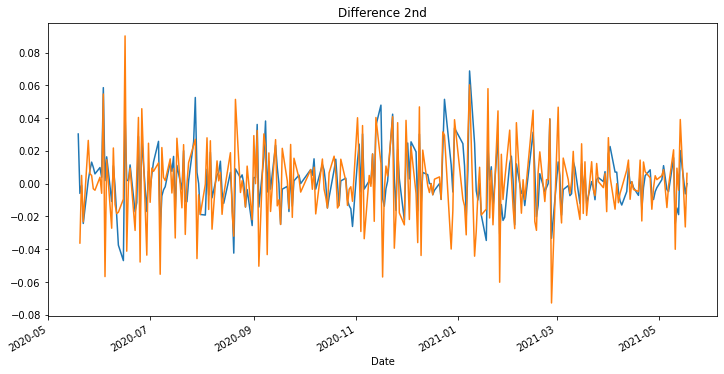

In [57]:
# 차분 안정성 확인 -> d 구하기

diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)


# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

### 추세 상쇄하기

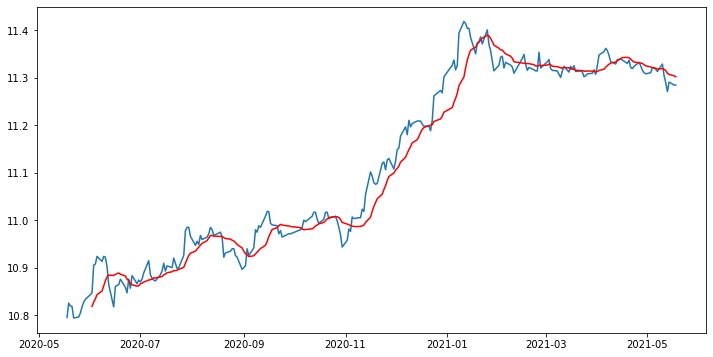

In [58]:
moving_avg = ts_log.rolling(window=12).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [59]:
ts_log_moving_avg = ts_log - moving_avg
ts_log_moving_avg.head(20)

Date
2020-05-18         NaN
2020-05-19         NaN
2020-05-20         NaN
2020-05-21         NaN
2020-05-22         NaN
2020-05-25         NaN
2020-05-26         NaN
2020-05-27         NaN
2020-05-28         NaN
2020-05-29         NaN
2020-06-01         NaN
2020-06-02    0.028599
2020-06-03    0.077956
2020-06-04    0.072953
2020-06-05    0.080606
2020-06-08    0.061862
2020-06-09    0.061925
2020-06-10    0.049636
2020-06-11    0.021446
2020-06-12   -0.019996
Name: Close, dtype: float64

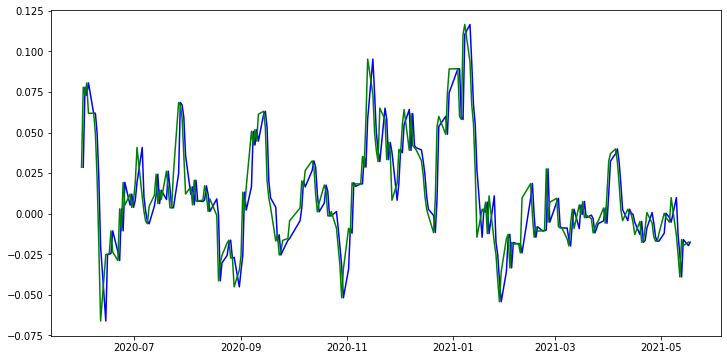

In [60]:
ts_log_moving_avg_shift = ts_log_moving_avg.shift(-1)


plt.plot(ts_log_moving_avg, color='blue')
plt.plot(ts_log_moving_avg_shift, color='green')

In [61]:
ts_log_moving_avg.dropna(inplace=True)
ts_log_moving_avg.head(20)

Date
2020-06-02    0.028599
2020-06-03    0.077956
2020-06-04    0.072953
2020-06-05    0.080606
2020-06-08    0.061862
2020-06-09    0.061925
2020-06-10    0.049636
2020-06-11    0.021446
2020-06-12   -0.019996
2020-06-15   -0.066141
2020-06-16   -0.025267
2020-06-17   -0.024961
2020-06-18   -0.024494
2020-06-19   -0.010603
2020-06-22   -0.023697
2020-06-23   -0.028907
2020-06-24    0.002950
2020-06-25   -0.010546
2020-06-26    0.019292
2020-06-29    0.005231
Name: Close, dtype: float64

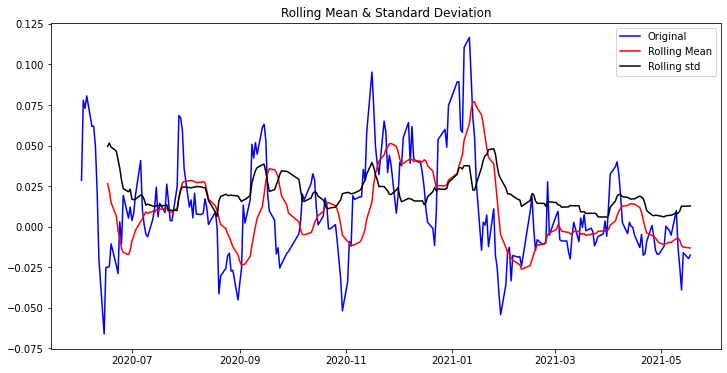

In [62]:
plot_rolling_statistics(ts_log_moving_avg)

In [63]:
augmented_dickey_fuller_test(ts_log_moving_avg)

Results of Dickey=Fuller Test:
Test Statistic                  -4.163469
p-value                          0.000759
#Lags Used                       0.000000
Number of Observations Used    238.000000
Critical Value (1%)             -3.458128
Critical Value (5%)             -2.873762
Critical Value (10%)            -2.573283
dtype: float64


In [64]:
moving_avg_6 = ts_log.rolling(window=6).mean()
ts_log_moving_avg_6 = ts_log - moving_avg_6
ts_log_moving_avg_6.dropna(inplace=True)

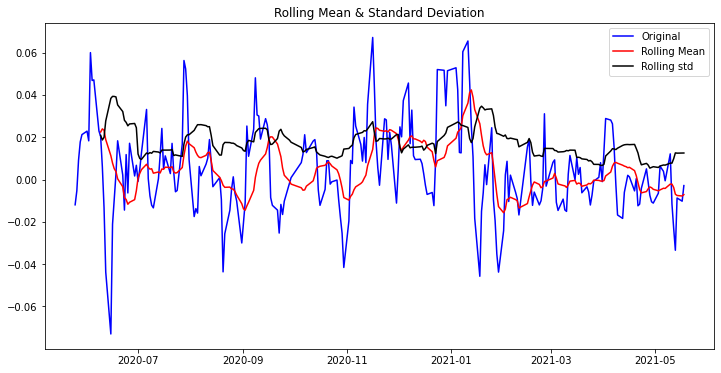

In [65]:
plot_rolling_statistics(ts_log_moving_avg_6)

In [66]:
augmented_dickey_fuller_test(ts_log_moving_avg_6)

Results of Dickey=Fuller Test:
Test Statistic                  -4.800754
p-value                          0.000054
#Lags Used                       5.000000
Number of Observations Used    239.000000
Critical Value (1%)             -3.458011
Critical Value (5%)             -2.873710
Critical Value (10%)            -2.573256
dtype: float64


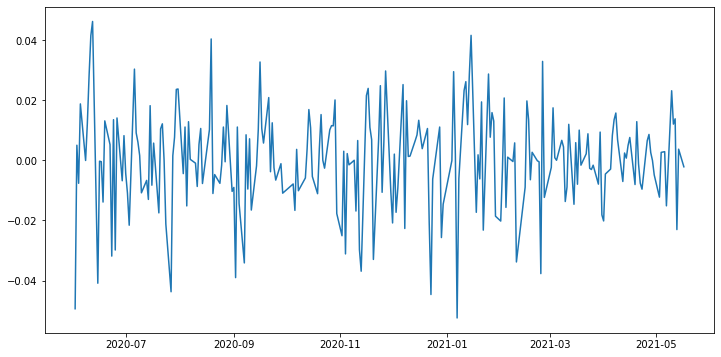

In [67]:
ts_log_moving_avg_diff = ts_log_moving_avg - ts_log_moving_avg_shift
ts_log_moving_avg_diff.dropna(inplace=True)
plt.plot(ts_log_moving_avg_diff)

In [68]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train_data, order=(2, 0, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 583.361
Date:                Mon, 04 Mar 2024   AIC                          -1156.722
Time:                        00:12:14   BIC                          -1139.642
Sample:                             0   HQIC                         -1149.828
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.0896      0.129     86.277      0.000      10.838      11.342
ar.L1          0.7739      1.821      0.425      0.671      -2.796       4.344
ar.L2          0.2191      1.811      0.121      0.9

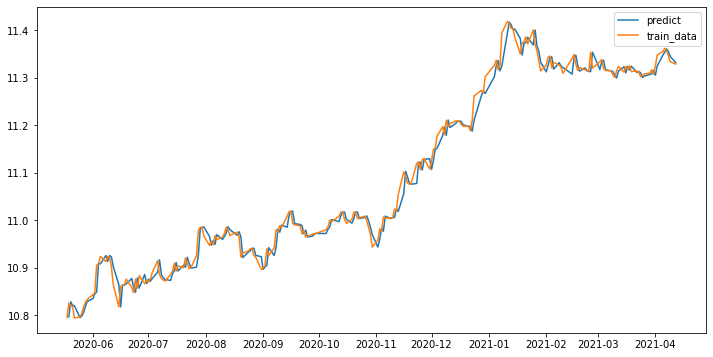

In [69]:
fitted_m = fitted_m.predict()
fitted_m = fitted_m.drop(fitted_m.index[0])
plt.plot(fitted_m, label='predict')
plt.plot(train_data, label='train_data')
plt.legend()

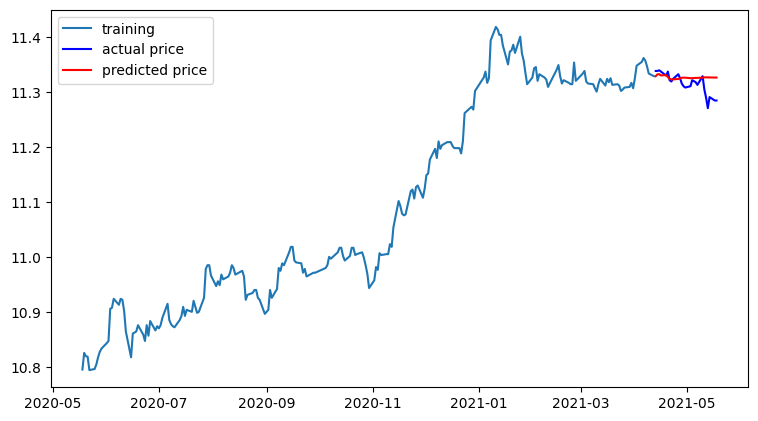

In [70]:
model = ARIMA(train_data, order=(14,1,0))
fitted_m = model.fit()
fc = fitted_m.forecast(len(test_data), alpha=0.5) # 95% conf
fc = np.array(fc)

fc_series = pd.Series(fc, index=test_data.index)

plt.figure(figsize=(9, 5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r', label='predicted price')
plt.legend()
plt.show()

In [71]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  3003612.7283351934
MAE:  1233.4874327617313
RMSE:  1733.0933986185491
MAPE: 1.53%


### 삼성주가_최근 주가 포함 

In [72]:
import yfinance as yf

# 삼성전자 주식 데이터 불러오기
samsung_electronics = yf.Ticker('005930.KS')  # '005930.KS'는 삼성전자의 종목 코드입니다. '.KS'는 한국 시장을 의미합니다.

# 시작일과 종료일 설정 (2020년 1월 1일부터 2024년 1월 31일까지)
start_date = '2000-01-01'
end_date = '2024-02-27'

# 데이터 가져오기 (과거부터 오늘까지의 데이터)
samsung_data = samsung_electronics.history(start=start_date, end=end_date)


# 날짜 형식 변경 및 인덱스 설정
samsung_data.index = pd.to_datetime(samsung_data.index).strftime('%Y-%m-%d')

# 데이터프레임 생성
df = pd.DataFrame(samsung_data,  columns=samsung_data.columns)

df


Open          High           Low         Close    Volume  \
Date                                                                           
2000-01-04   4389.458240   4469.931641   4140.722273   4469.931641  74195000   
2000-01-05   4243.142589   4433.352429   4038.301222   4082.195801  74680000   
2000-01-06   4206.563408   4228.510695   4082.195446   4111.458496  54390000   
2000-01-07   4067.567083   4148.040533   3921.251720   4052.935547  40305000   
2000-01-10   4096.826866   4221.194824   4082.195341   4221.194824  46880000   
...                  ...           ...           ...           ...       ...   
2024-02-20  73700.000000  73700.000000  72800.000000  73300.000000  14681477   
2024-02-21  73400.000000  73700.000000  72900.000000  73000.000000  11503495   
2024-02-22  73800.000000  73900.000000  72700.000000  73100.000000  15208934   
2024-02-23  73600.000000  74200.000000  72900.000000  72900.000000  16225166   
2024-02-26  72300.000000  73200.000000  72200.000000  72800.000000  14669352   

            Dividends  Stock Splits  
Date                                 
2000-01-04        0.0           0.0  
2000-01-05        0.0           0.0  
2000-01-06        0.0           0.0  
2000-01-07        0.0           0.0  
2000-01-10        0.0           0.0  
...               ...           ...  
2024-02-20        0.0           0.0  
2024-02-21        0.0           0.0  
2024-02-22        0.0           0.0  
2024-02-23        0.0           0.0  
2024-02-26        0.0           0.0  

[6055 rows x 7 columns]

In [73]:
ts = df['Close']
ts

Date
2000-01-04     4469.931641
2000-01-05     4082.195801
2000-01-06     4111.458496
2000-01-07     4052.935547
2000-01-10     4221.194824
                  ...     
2024-02-20    73300.000000
2024-02-21    73000.000000
2024-02-22    73100.000000
2024-02-23    72900.000000
2024-02-26    72800.000000
Name: Close, Length: 6055, dtype: float64

In [74]:
ts = ts.interpolate(method='time')
# ts[ts.isna()]

ValueError: time-weighted interpolation only works on Series or DataFrames with a DatetimeIndex

In [75]:
ts.fillna(0)

Date
2000-01-04     4469.931641
2000-01-05     4082.195801
2000-01-06     4111.458496
2000-01-07     4052.935547
2000-01-10     4221.194824
                  ...     
2024-02-20    73300.000000
2024-02-21    73000.000000
2024-02-22    73100.000000
2024-02-23    72900.000000
2024-02-26    72800.000000
Name: Close, Length: 6055, dtype: float64

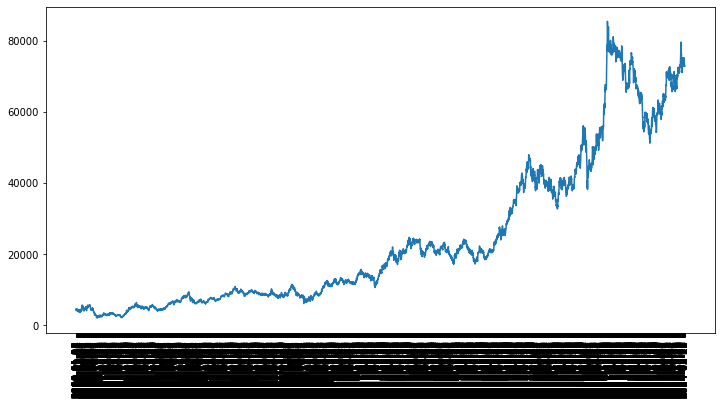

In [76]:
plt.plot(ts)

# x 축 라벨 각도 조정
plt.xticks(rotation=90)

# 그래프 표시
plt.show()

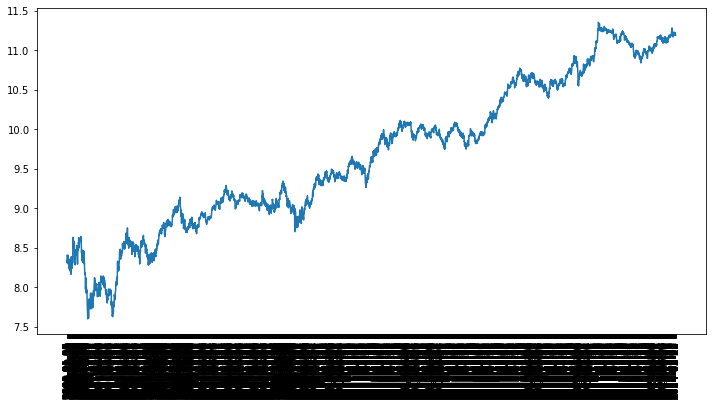

In [77]:
ts_log = np.log(ts)
plt.plot(ts_log)

# x 축 라벨 각도 조정
plt.xticks(rotation=90)

# 그래프 표시
plt.show()

In [78]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()
    rolstd = timeseries.rolling(window=window).std()
    
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

In [79]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    dftest = adfuller(timeseries, autolag='AIC')
    
    print('Results of Dickey=Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

구간 통계치(Rolling Statistics)를 시각화 & 검정을 통해 정상성 확인하기

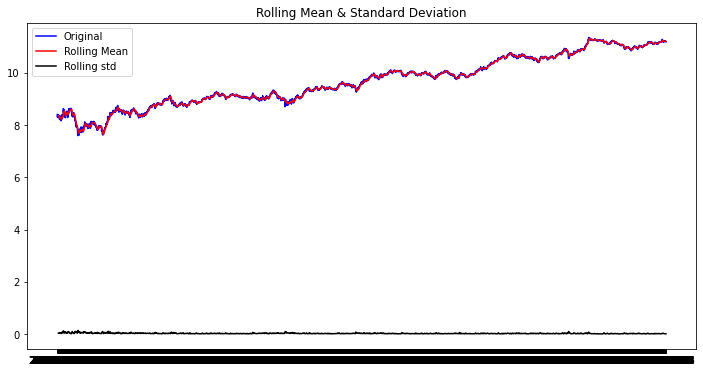

Results of Dickey=Fuller Test:
Test Statistic                   -0.591388
p-value                           0.872916
#Lags Used                        4.000000
Number of Observations Used    6050.000000
Critical Value (1%)              -3.431431
Critical Value (5%)              -2.862018
Critical Value (10%)             -2.567024
dtype: float64


In [80]:
plot_rolling_statistics(ts_log, window=12)

# 정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

계절성 추세 확인하기

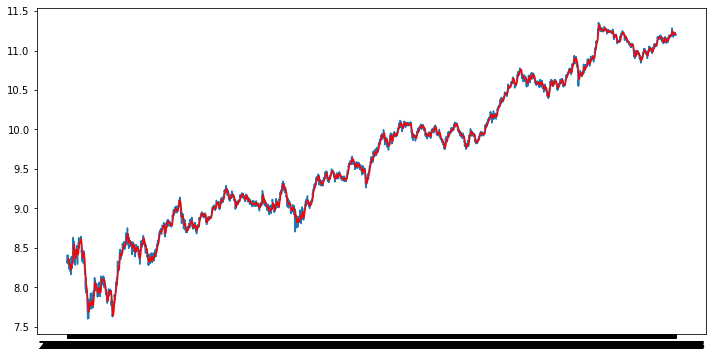

In [81]:
moving_avg = ts_log.rolling(window=12).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [82]:
ts_log_moving_avg = ts_log - moving_avg
ts_log_moving_avg.head(20)

Date
2000-01-04         NaN
2000-01-05         NaN
2000-01-06         NaN
2000-01-07         NaN
2000-01-10         NaN
2000-01-11         NaN
2000-01-12         NaN
2000-01-13         NaN
2000-01-14         NaN
2000-01-17         NaN
2000-01-18         NaN
2000-01-19    0.024767
2000-01-20    0.039061
2000-01-21    0.007850
2000-01-24   -0.024419
2000-01-25   -0.069588
2000-01-26   -0.057964
2000-01-27   -0.047001
2000-01-28    0.004477
2000-01-31   -0.035715
Name: Close, dtype: float64

In [83]:
ts_log_moving_avg.dropna(inplace=True)
ts_log_moving_avg.head(20)

Date
2000-01-19    0.024767
2000-01-20    0.039061
2000-01-21    0.007850
2000-01-24   -0.024419
2000-01-25   -0.069588
2000-01-26   -0.057964
2000-01-27   -0.047001
2000-01-28    0.004477
2000-01-31   -0.035715
2000-02-01   -0.075802
2000-02-02   -0.076542
2000-02-03   -0.085232
2000-02-04   -0.072735
2000-02-07   -0.039679
2000-02-08    0.002573
2000-02-09    0.054311
2000-02-10    0.056516
2000-02-11    0.042765
2000-02-14   -0.012872
2000-02-15   -0.037515
Name: Close, dtype: float64

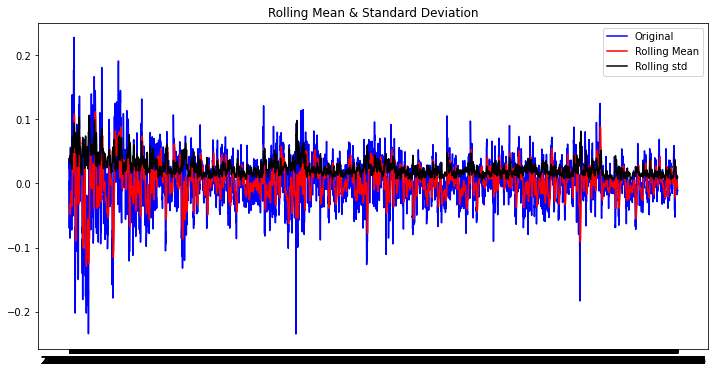

In [84]:
plot_rolling_statistics(ts_log_moving_avg)

In [85]:
augmented_dickey_fuller_test(ts_log_moving_avg)

Results of Dickey=Fuller Test:
Test Statistic                -1.771016e+01
p-value                        3.505229e-30
#Lags Used                     1.100000e+01
Number of Observations Used    6.032000e+03
Critical Value (1%)           -3.431435e+00
Critical Value (5%)           -2.862019e+00
Critical Value (10%)          -2.567025e+00
dtype: float64


p-valuer가 0.05 보다 작아서 유의수준임을 확인했음

차분(Differencing) - 계절성(Seasonality) 상쇄하기

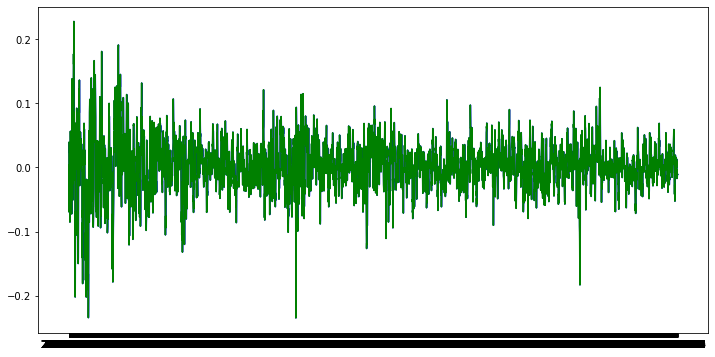

In [86]:
ts_log_moving_avg_shift = ts_log_moving_avg.shift(-1)


plt.plot(ts_log_moving_avg, color='blue')
plt.plot(ts_log_moving_avg_shift, color='green')

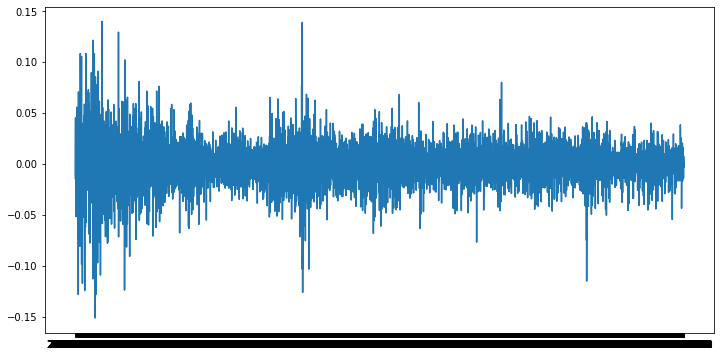

In [87]:
ts_log_moving_avg_diff = ts_log_moving_avg - ts_log_moving_avg_shift
ts_log_moving_avg_diff.dropna(inplace=True)
plt.plot(ts_log_moving_avg_diff)

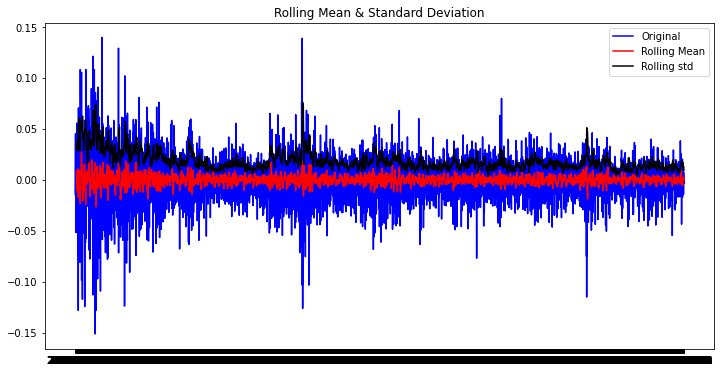

In [88]:
plot_rolling_statistics(ts_log_moving_avg_diff)

In [89]:
augmented_dickey_fuller_test(ts_log_moving_avg_diff)

Results of Dickey=Fuller Test:
Test Statistic                  -21.119140
p-value                           0.000000
#Lags Used                       33.000000
Number of Observations Used    6009.000000
Critical Value (1%)              -3.431439
Critical Value (5%)              -2.862021
Critical Value (10%)             -2.567026
dtype: float64


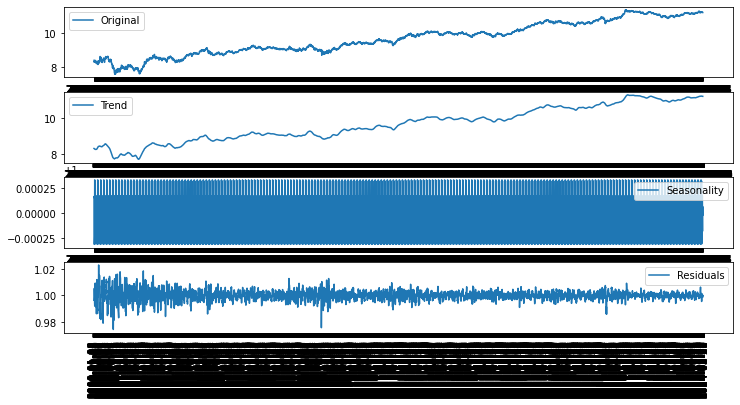

<Figure size 864x432 with 0 Axes>

In [90]:
# 시계열 분해 
from statsmodels.tsa.seasonal import seasonal_decompose
decompostition = seasonal_decompose(ts_log, model='multiplicative', period=30)

trend = decompostition.trend
seasonal = decompostition.seasonal
residual = decompostition.resid



plt.rcParams['figure.figsize'] = (12,6)

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

plt.xticks(rotation=90)

plt.show()

plt.tight_layout()

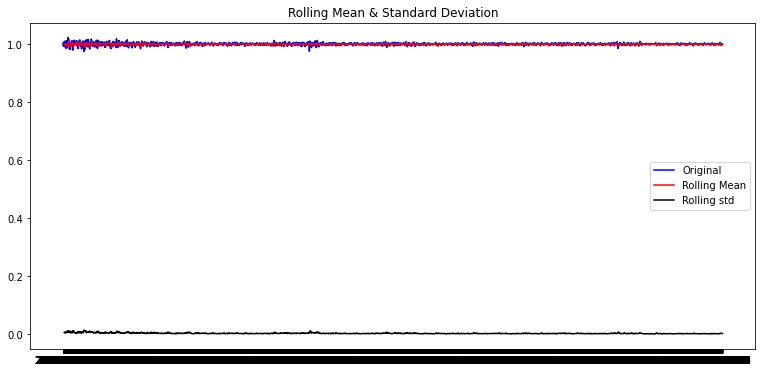

In [91]:
residual.dropna(inplace=True)
plt.rcParams['figure.figsize'] = (13,6)
plot_rolling_statistics(residual)

In [92]:
augmented_dickey_fuller_test(residual)

Results of Dickey=Fuller Test:
Test Statistic                  -18.879085
p-value                           0.000000
#Lags Used                       33.000000
Number of Observations Used    5991.000000
Critical Value (1%)              -3.431442
Critical Value (5%)              -2.862023
Critical Value (10%)             -2.567027
dtype: float64


Results of Dickey=Fuller Test:
Test Statistic                  -42.769256
p-value                           0.000000
#Lags Used                        3.000000
Number of Observations Used    6050.000000
Critical Value (1%)              -3.431431
Critical Value (5%)              -2.862018
Critical Value (10%)             -2.567024
dtype: float64


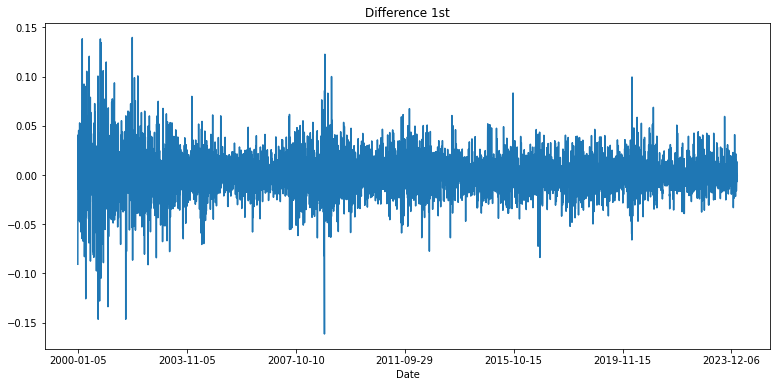

In [93]:
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')
augmented_dickey_fuller_test(diff_1)

Results of Dickey=Fuller Test:
Test Statistic                  -22.955010
p-value                           0.000000
#Lags Used                       34.000000
Number of Observations Used    6018.000000
Critical Value (1%)              -3.431437
Critical Value (5%)              -2.862020
Critical Value (10%)             -2.567026
dtype: float64


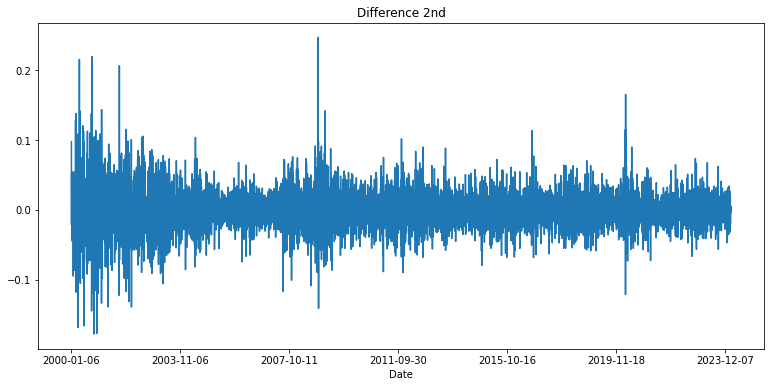

In [94]:
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

<AxesSubplot:title={'center':'Difference 2nd'}, xlabel='Date'>

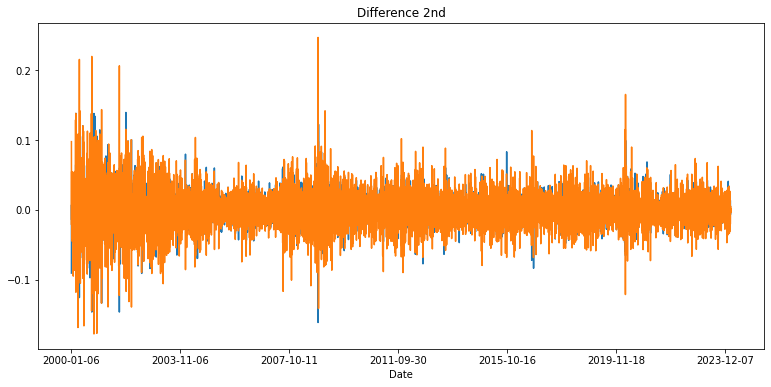

In [95]:
diff_1.plot(title='Difference 1st')
diff_2.plot(title='Difference 2nd')

차분은 1차분으로해도 충분해 보임

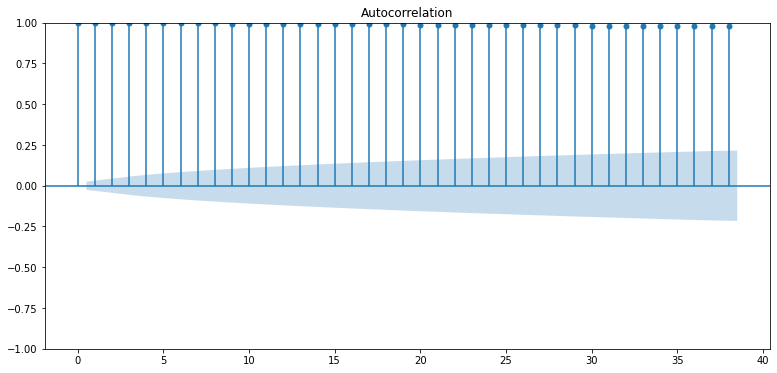

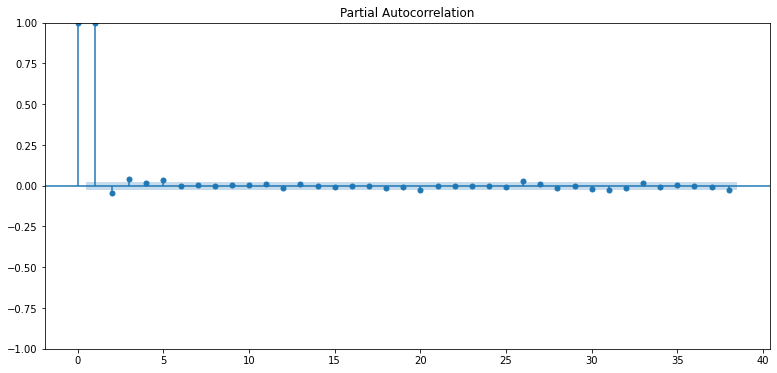

In [96]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


plot_acf(ts_log)
plot_pacf(ts_log)
plt.show()

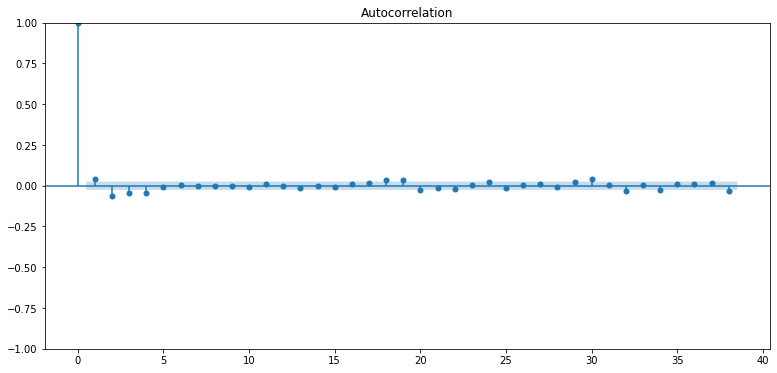

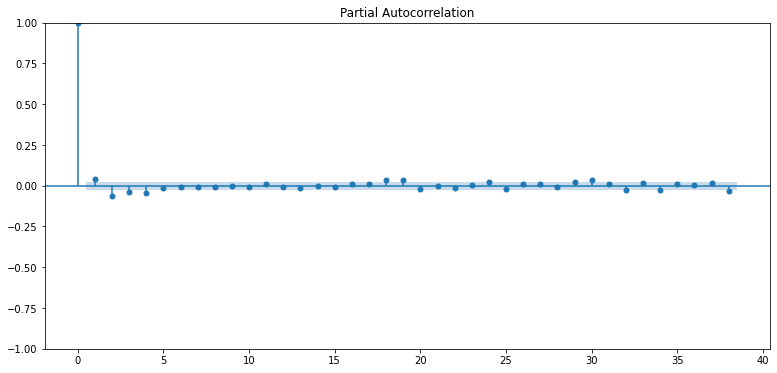

In [97]:
plot_acf(diff_1)
plot_pacf(diff_1)
plt.show()

학습 데이터 분리

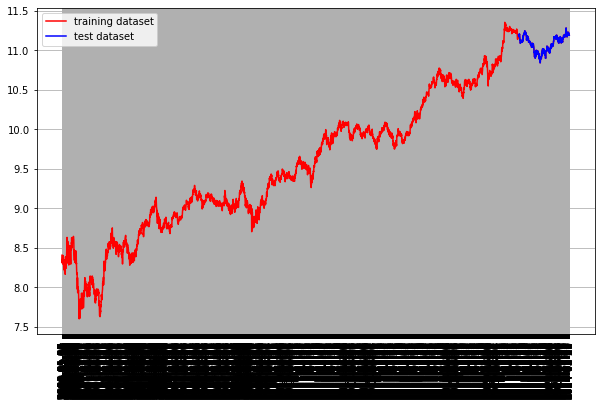

In [98]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]

plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')
plt.plot(test_data, c='b', label='test dataset')
plt.xticks(rotation=90)
plt.legend()

ARIMA의 모수는 3가지

- p : 자기회귀 모형(AR)의 시차
- d : 차분 누적(I) 횟수
- q : 이동평균 모형(MA)의 시차

p: 1 d:1 , q:0 으로 진행

 p 와 q 는 일반적으로 p + q < 2, p * q = 0 인 값을 사용하는데, 이는 p 나 q 중 하나는 0이라는 뜻입니다. 이렇게 하는 이유는 많은 시계열 데이터가 AR이나 MA 중 하나의 경향만 가지기 때문

In [99]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 5449
Model:                 ARIMA(1, 1, 0)   Log Likelihood               12989.793
Date:                Mon, 04 Mar 2024   AIC                         -25975.586
Time:                        00:16:15   BIC                         -25962.380
Sample:                             0   HQIC                        -25970.978
                               - 5449                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0416      0.009      4.493      0.000       0.023       0.060
sigma2         0.0005   5.23e-06     95.119      0.000       0.000       0.001
Ljung-Box (L1) (Q):                   0.02   Jarque-

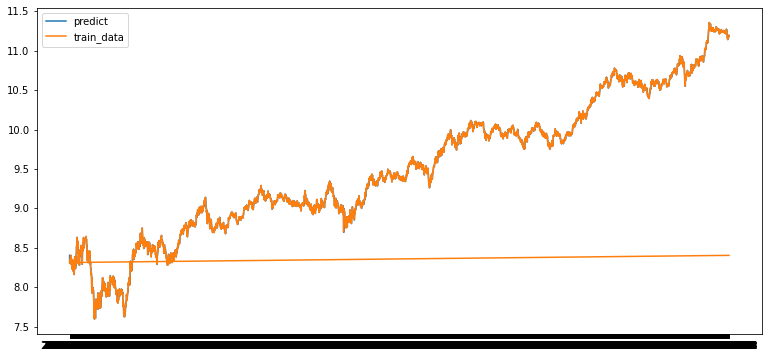

In [100]:
fitted_m = fitted_m.predict()
fitted_m = fitted_m.drop(fitted_m.index[0])
plt.plot(fitted_m, label='predict')
plt.plot(train_data, label='train_data')
plt.legend()

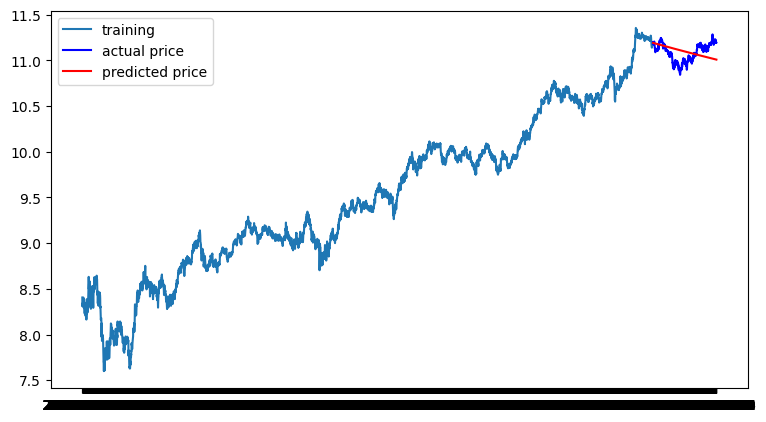

In [101]:
model = ARIMA(train_data, order=(1,0,1))
fitted_m = model.fit()
fc = fitted_m.forecast(len(test_data), alpha=0.5) # 95% conf
fc = np.array(fc)

fc_series = pd.Series(fc, index=test_data.index)

plt.figure(figsize=(9, 5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r', label='predicted price')
plt.legend()
plt.show()

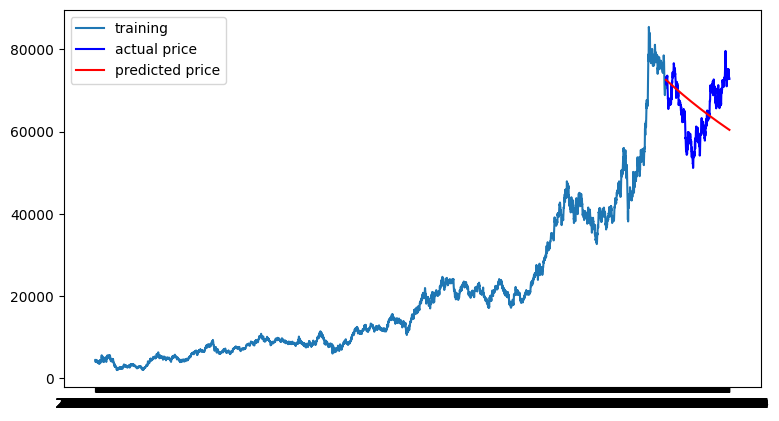

In [102]:
plt.figure(figsize=(9, 5), dpi=100)
plt.plot(np.exp(train_data), label='training')
plt.plot(np.exp(test_data), c='b', label='actual price')
plt.plot(np.exp(fc_series), c='r', label='predicted price')
plt.legend()
plt.show()

In [103]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  58580036.25019202
MAE:  6512.768281466038
RMSE:  7653.759615391119
MAPE: 10.19%


In [104]:
from statsmodels.tsa.arima.model import ARIMA
# 이동평균을 12 했을때 확인
model = ARIMA(train_data, order=(0, 1, 12))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 5449
Model:                ARIMA(0, 1, 12)   Log Likelihood               13011.385
Date:                Mon, 04 Mar 2024   AIC                         -25996.771
Time:                        00:17:01   BIC                         -25910.932
Sample:                             0   HQIC                        -25966.816
                               - 5449                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0372      0.010      3.892      0.000       0.018       0.056
ma.L2         -0.0639      0.009     -6.735      0.000      -0.083      -0.045
ma.L3         -0.0384      0.010     -3.803      0.0

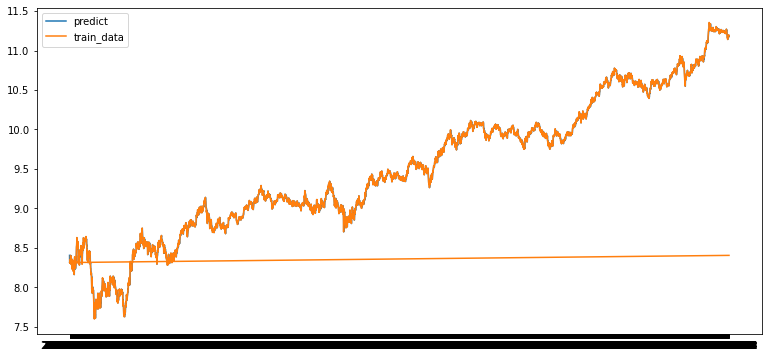

In [105]:
fitted_m = fitted_m.predict()
fitted_m = fitted_m.drop(fitted_m.index[0])
plt.plot(fitted_m, label='predict')
plt.plot(train_data, label='train_data')
plt.legend()

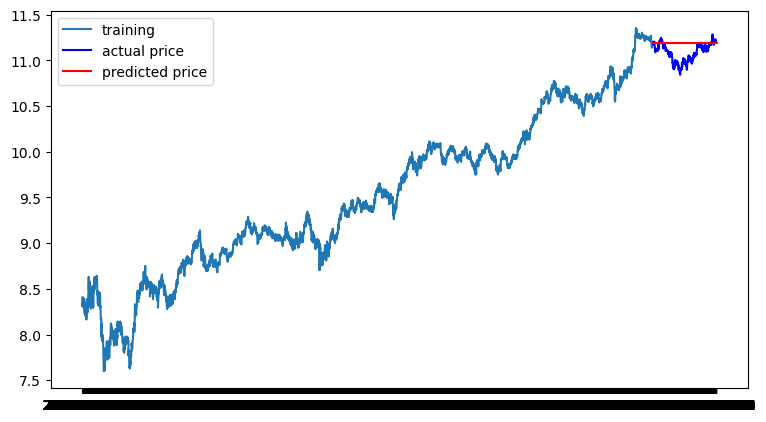

In [106]:
model = ARIMA(train_data, order=(0, 1, 12))  
fitted_m = model.fit()
fc = fitted_m.forecast(len(test_data), alpha=0.5) # 95% conf
fc = np.array(fc)

fc_series = pd.Series(fc, index=test_data.index)

plt.figure(figsize=(9, 5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r', label='predicted price')
plt.legend()
plt.show()

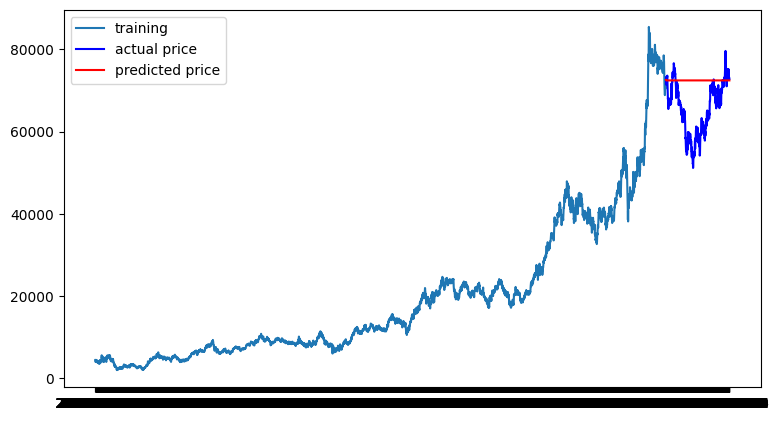

In [107]:
plt.figure(figsize=(9, 5), dpi=100)
plt.plot(np.exp(train_data), label='training')
plt.plot(np.exp(test_data), c='b', label='actual price')
plt.plot(np.exp(fc_series), c='r', label='predicted price')
plt.legend()
plt.show()

In [108]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  86863561.80704737
MAE:  7403.854628426074
RMSE:  9320.062328495844
MAPE: 12.25%


In [109]:
from statsmodels.tsa.arima.model import ARIMA
# 이동평균을 4 했을때 확인
model = ARIMA(train_data, order=(0, 1, 4))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 5449
Model:                 ARIMA(0, 1, 4)   Log Likelihood               13010.835
Date:                Mon, 04 Mar 2024   AIC                         -26011.671
Time:                        00:17:46   BIC                         -25978.656
Sample:                             0   HQIC                        -26000.150
                               - 5449                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0400      0.009      4.272      0.000       0.022       0.058
ma.L2         -0.0634      0.009     -6.739      0.000      -0.082      -0.045
ma.L3         -0.0412      0.010     -4.186      0.0

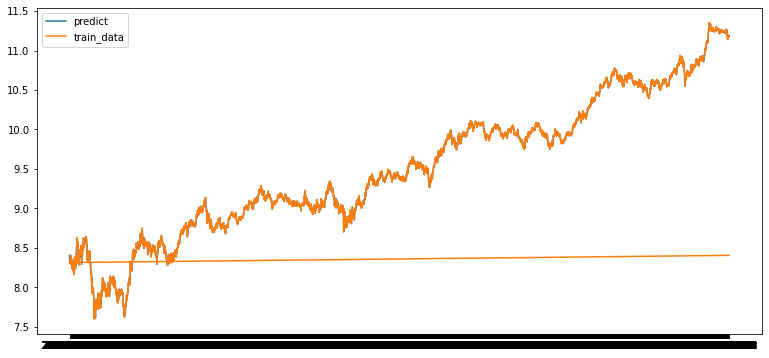

In [110]:
fitted_m = fitted_m.predict()
fitted_m = fitted_m.drop(fitted_m.index[0])
plt.plot(fitted_m, label='predict')
plt.plot(train_data, label='train_data')
plt.legend()

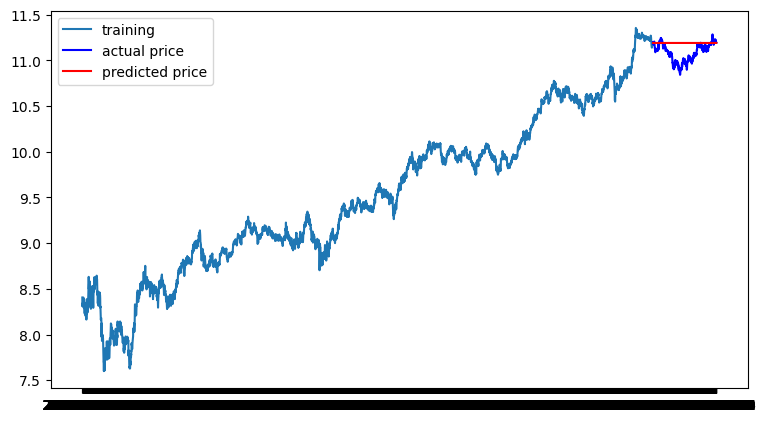

In [111]:
model = ARIMA(train_data, order=(0, 1, 4))  
fitted_m = model.fit()
fc = fitted_m.forecast(len(test_data), alpha=0.5) # 95% conf
fc = np.array(fc)

fc_series = pd.Series(fc, index=test_data.index)

plt.figure(figsize=(9, 5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r', label='predicted price')
plt.legend()
plt.show()

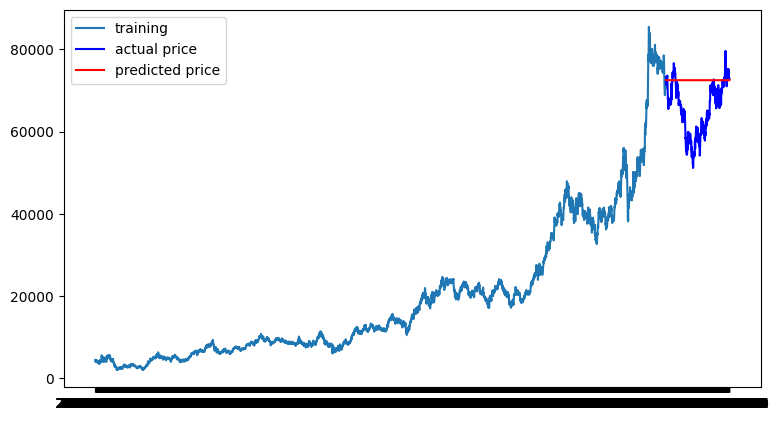

In [112]:
plt.figure(figsize=(9, 5), dpi=100)
plt.plot(np.exp(train_data), label='training')
plt.plot(np.exp(test_data), c='b', label='actual price')
plt.plot(np.exp(fc_series), c='r', label='predicted price')
plt.legend()
plt.show()

In [113]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  87538972.9926942
MAE:  7437.925448930016
RMSE:  9356.226429105604
MAPE: 12.30%


order=(1,0,1)) 가 가장 좋았다.

MSE:  58580021.85184506<br>
MAE:  6512.767548274643<br>
RMSE:  7653.758674784897<br>
MAPE: 10.19%

## 아이온큐

In [114]:
import yfinance as yf

ionq = yf.Ticker('IONQ')  # '005930.KS'는 삼성전자의 종목 코드입니다. '.KS'는 한국 시장을 의미합니다.



# 데이터 가져오기 (과거부터 오늘까지의 데이터)
ionq_data = ionq.history(period='max')


# 날짜 형식 변경 및 인덱스 설정
ionq_data.index = pd.to_datetime(ionq_data.index).strftime('%Y-%m-%d')

# 데이터프레임 생성
df = pd.DataFrame(ionq_data,  columns=ionq_data.columns)

df


Open    High    Low  Close    Volume  Dividends  Stock Splits
Date                                                                       
2021-01-04  11.125  11.250  10.50  10.80    150500        0.0           0.0
2021-01-05  10.850  11.830  10.75  11.11    165300        0.0           0.0
2021-01-06  11.500  11.500  11.00  11.05    175600        0.0           0.0
2021-01-07  11.500  11.500  11.05  11.11     94200        0.0           0.0
2021-01-08  11.650  12.350  11.00  11.01    137500        0.0           0.0
...            ...     ...    ...    ...       ...        ...           ...
2024-02-26  10.820  11.300  10.77  11.24   6379300        0.0           0.0
2024-02-27  11.430  11.676  11.24  11.57   7447000        0.0           0.0
2024-02-28  11.300  11.629  11.16  11.26  12725100        0.0           0.0
2024-02-29  11.710  11.720  10.20  10.36  26317500        0.0           0.0
2024-03-01  10.310  10.860  10.17  10.66  10174300        0.0           0.0

[795 rows x 7 columns]

In [115]:
ts = df['Close']
ts

Date
2021-01-04    10.80
2021-01-05    11.11
2021-01-06    11.05
2021-01-07    11.11
2021-01-08    11.01
              ...  
2024-02-26    11.24
2024-02-27    11.57
2024-02-28    11.26
2024-02-29    10.36
2024-03-01    10.66
Name: Close, Length: 795, dtype: float64

In [116]:
ts = ts.interpolate(method='time')
ts[ts.isna()]

ValueError: time-weighted interpolation only works on Series or DataFrames with a DatetimeIndex

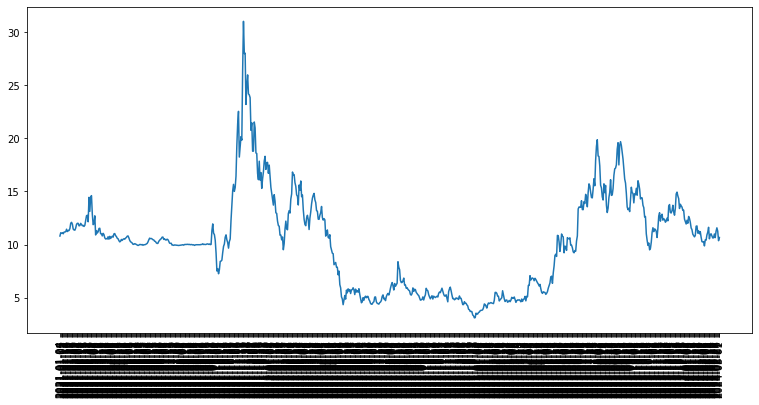

In [117]:
plt.plot(ts)

# x 축 라벨 각도 조정
plt.xticks(rotation=90)

# 그래프 표시
plt.show()

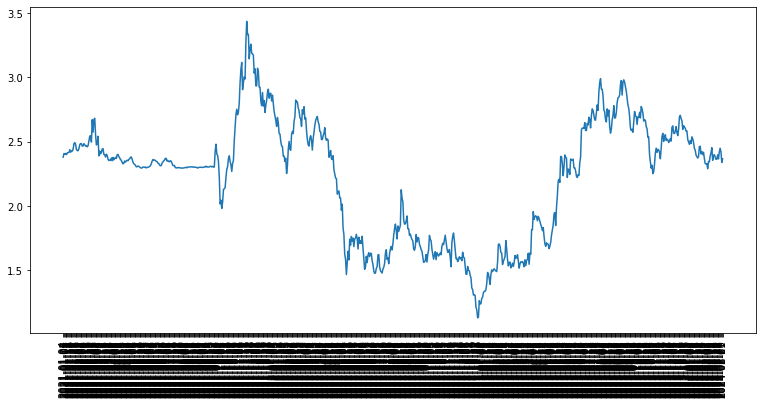

In [118]:
ts_log = np.log(ts)
plt.plot(ts_log)

# x 축 라벨 각도 조정
plt.xticks(rotation=90)

# 그래프 표시
plt.show()

구간 통계치(Rolling Statistics)를 시각화 & 검정을 통해 정상성 확인하기

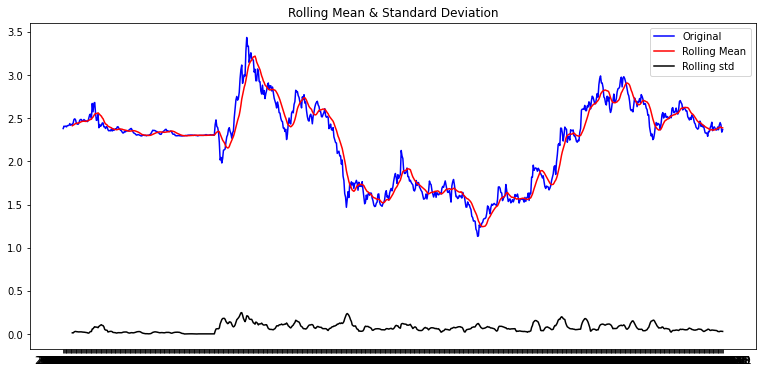

In [119]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

In [120]:
#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

Results of Dickey=Fuller Test:
Test Statistic                  -1.825774
p-value                          0.367743
#Lags Used                      16.000000
Number of Observations Used    778.000000
Critical Value (1%)             -3.438783
Critical Value (5%)             -2.865262
Critical Value (10%)            -2.568752
dtype: float64


계절성 추세 확인하기

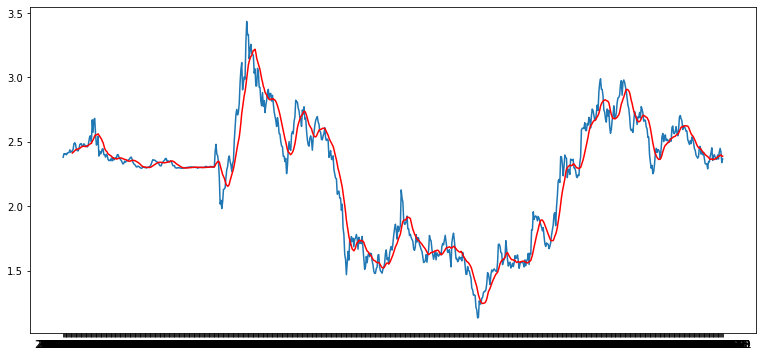

In [121]:
moving_avg = ts_log.rolling(window=12).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [122]:
ts_log_moving_avg = ts_log - moving_avg
ts_log_moving_avg.head(20)

Date
2021-01-04         NaN
2021-01-05         NaN
2021-01-06         NaN
2021-01-07         NaN
2021-01-08         NaN
2021-01-11         NaN
2021-01-12         NaN
2021-01-13         NaN
2021-01-14         NaN
2021-01-15         NaN
2021-01-19         NaN
2021-01-20    0.014263
2021-01-21    0.024805
2021-01-22    0.060943
2021-01-25    0.060920
2021-01-26    0.040125
2021-01-27   -0.002529
2021-01-28   -0.011020
2021-01-29   -0.014038
2021-02-01    0.000866
Name: Close, dtype: float64

In [123]:
ts_log_moving_avg.dropna(inplace=True)
ts_log_moving_avg.head(20)

Date
2021-01-20    0.014263
2021-01-21    0.024805
2021-01-22    0.060943
2021-01-25    0.060920
2021-01-26    0.040125
2021-01-27   -0.002529
2021-01-28   -0.011020
2021-01-29   -0.014038
2021-02-01    0.000866
2021-02-02    0.027433
2021-02-03    0.030201
2021-02-04    0.024575
2021-02-05    0.002029
2021-02-08    0.001723
2021-02-09    0.019462
2021-02-10    0.011706
2021-02-11    0.003389
2021-02-12    0.003425
2021-02-16   -0.007470
2021-02-17   -0.001422
Name: Close, dtype: float64

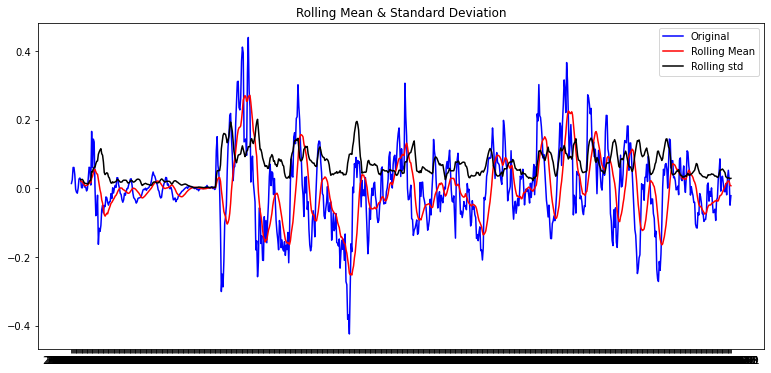

In [124]:
plot_rolling_statistics(ts_log_moving_avg)

In [125]:
augmented_dickey_fuller_test(ts_log_moving_avg)

Results of Dickey=Fuller Test:
Test Statistic                -6.636527e+00
p-value                        5.544788e-09
#Lags Used                     1.500000e+01
Number of Observations Used    7.680000e+02
Critical Value (1%)           -3.438893e+00
Critical Value (5%)           -2.865311e+00
Critical Value (10%)          -2.568778e+00
dtype: float64


p-valuer가 0.05 보다 작아서 유의수준임을 확인했음

차분(Differencing) - 계절성(Seasonality) 상쇄하기

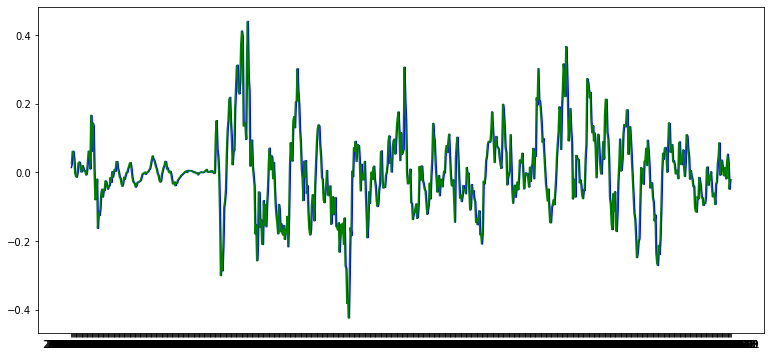

In [126]:
ts_log_moving_avg_shift = ts_log_moving_avg.shift(-1)


plt.plot(ts_log_moving_avg, color='blue')
plt.plot(ts_log_moving_avg_shift, color='green')

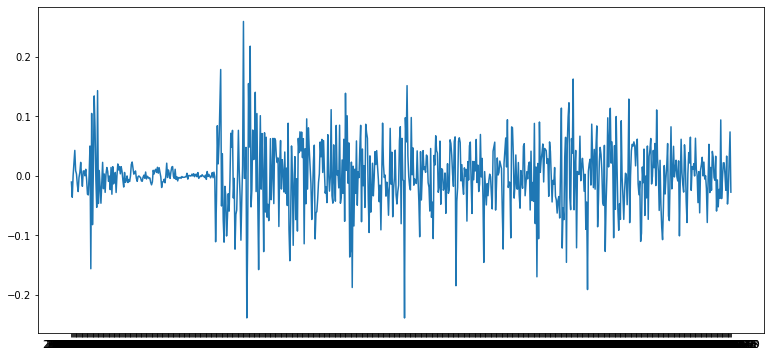

In [127]:
ts_log_moving_avg_diff = ts_log_moving_avg - ts_log_moving_avg_shift
ts_log_moving_avg_diff.dropna(inplace=True)
plt.plot(ts_log_moving_avg_diff)

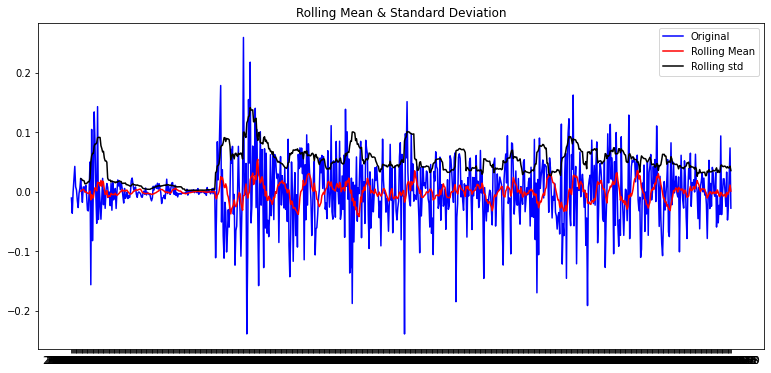

In [128]:
plot_rolling_statistics(ts_log_moving_avg_diff)

In [129]:
augmented_dickey_fuller_test(ts_log_moving_avg_diff)

Results of Dickey=Fuller Test:
Test Statistic                -1.046558e+01
p-value                        1.324405e-18
#Lags Used                     1.800000e+01
Number of Observations Used    7.640000e+02
Critical Value (1%)           -3.438938e+00
Critical Value (5%)           -2.865330e+00
Critical Value (10%)          -2.568788e+00
dtype: float64


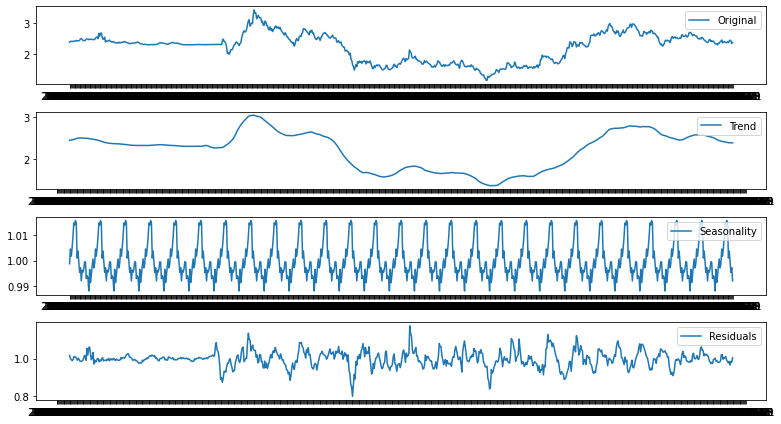

In [130]:
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 


plt.rcParams['figure.figsize'] = (11,6)


trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

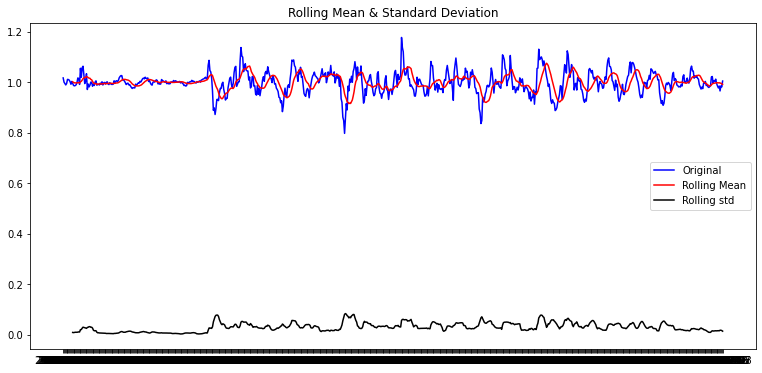

In [131]:
residual.dropna(inplace=True)
plt.rcParams['figure.figsize'] = (13,6)
plot_rolling_statistics(residual)

In [132]:
augmented_dickey_fuller_test(residual)

Results of Dickey=Fuller Test:
Test Statistic                -9.816654e+00
p-value                        5.474916e-17
#Lags Used                     1.400000e+01
Number of Observations Used    7.500000e+02
Critical Value (1%)           -3.439099e+00
Critical Value (5%)           -2.865401e+00
Critical Value (10%)          -2.568826e+00
dtype: float64


Results of Dickey=Fuller Test:
Test Statistic                -7.195309e+00
p-value                        2.443374e-10
#Lags Used                     1.500000e+01
Number of Observations Used    7.780000e+02
Critical Value (1%)           -3.438783e+00
Critical Value (5%)           -2.865262e+00
Critical Value (10%)          -2.568752e+00
dtype: float64


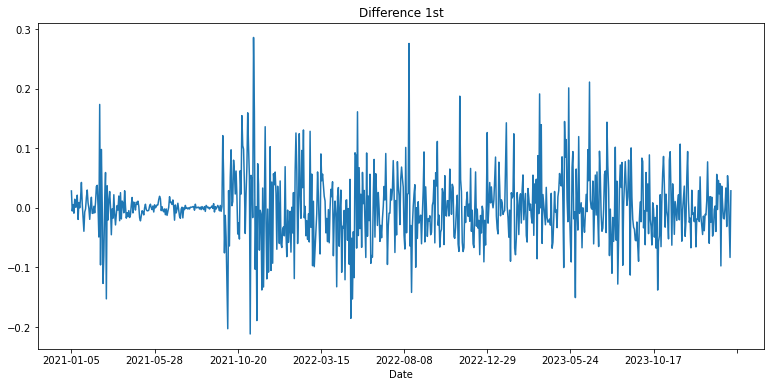

In [133]:
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')
augmented_dickey_fuller_test(diff_1)      

Results of Dickey=Fuller Test:
Test Statistic                -1.016878e+01
p-value                        7.181102e-18
#Lags Used                     2.000000e+01
Number of Observations Used    7.720000e+02
Critical Value (1%)           -3.438849e+00
Critical Value (5%)           -2.865291e+00
Critical Value (10%)          -2.568767e+00
dtype: float64


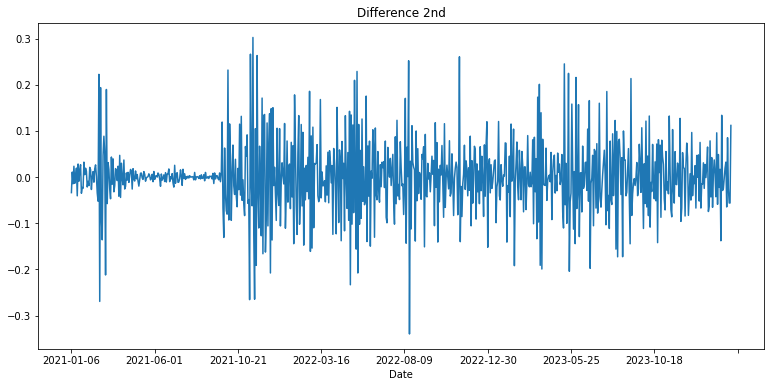

In [134]:
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

<AxesSubplot:title={'center':'Difference 2nd'}, xlabel='Date'>

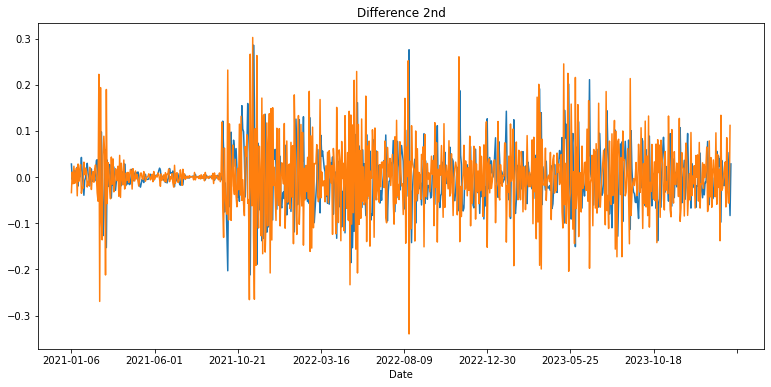

In [135]:
diff_1.plot(title='Difference 1st')
diff_2.plot(title='Difference 2nd')

1차분 충분해 보임

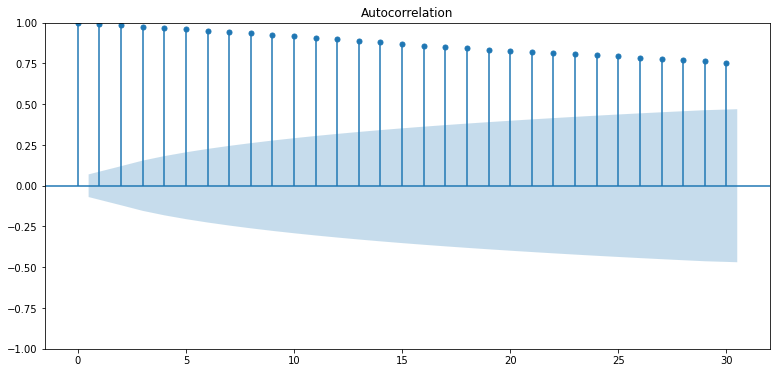

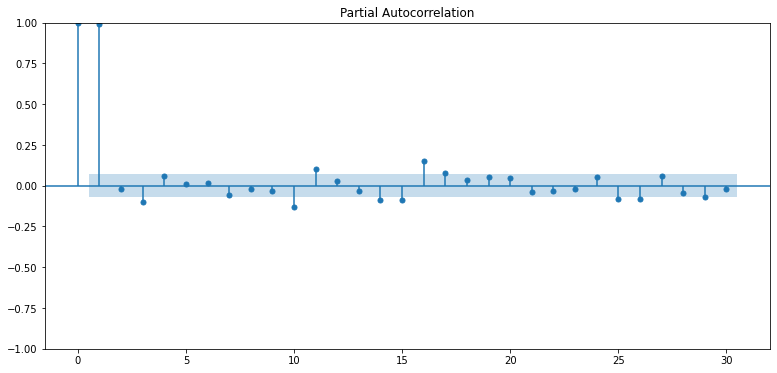

In [136]:
plot_acf(ts_log)
plot_pacf(ts_log)
plt.show()

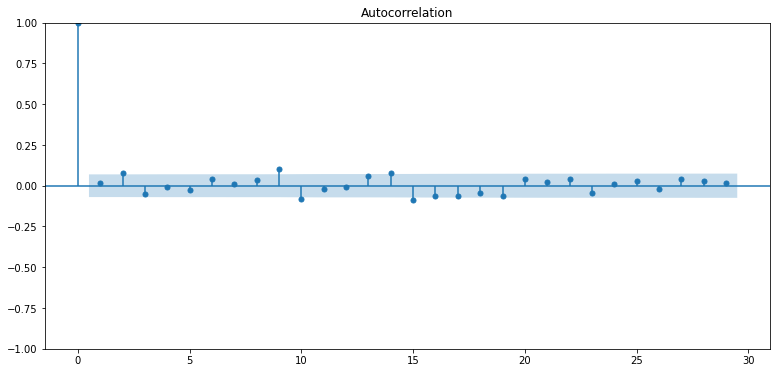

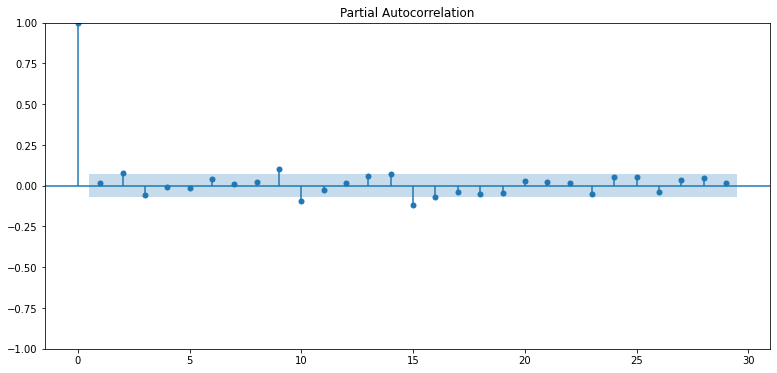

In [137]:
plot_acf(diff_1)
plot_pacf(diff_1)
plt.show()

q,p값이 1~2 적합하게 보임

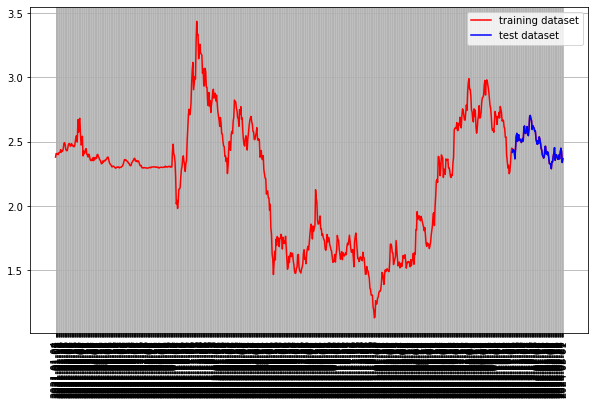

In [138]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]

plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')
plt.plot(test_data, c='b', label='test dataset')
plt.xticks(rotation=90)
plt.legend()

p: 2 d:1 , q:0 으로 진행

 p 와 q 는 일반적으로 p + q < 2, p * q = 0 인 값을 사용하는데, 이는 p 나 q 중 하나는 0이라는 뜻입니다. 이렇게 하는 이유는 많은 시계열 데이터가 AR이나 MA 중 하나의 경향만 가지기 때문

In [139]:
model = ARIMA(train_data, order=(2, 1, 0))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  715
Model:                 ARIMA(2, 1, 0)   Log Likelihood                1032.996
Date:                Mon, 04 Mar 2024   AIC                          -2059.991
Time:                        00:21:32   BIC                          -2046.279
Sample:                             0   HQIC                         -2054.695
                                - 715                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0174      0.032      0.547      0.584      -0.045       0.080
ar.L2          0.0898      0.029      3.053      0.002       0.032       0.147
sigma2         0.0032      0.000     28.741      0.0

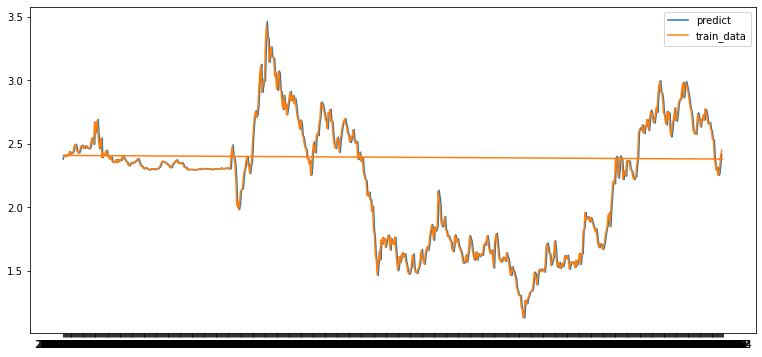

In [140]:
fitted_m = fitted_m.predict()
fitted_m = fitted_m.drop(fitted_m.index[0])
plt.plot(fitted_m, label='predict')
plt.plot(train_data, label='train_data')
plt.legend()

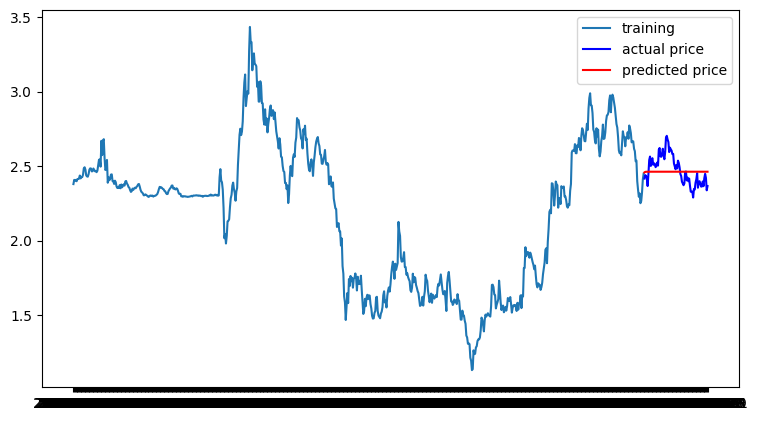

In [141]:
model = ARIMA(train_data, order=(2, 1, 0))  
fitted_m = model.fit()
fc = fitted_m.forecast(len(test_data), alpha=0.5) # 95% conf
fc = np.array(fc)

fc_series = pd.Series(fc, index=test_data.index)

plt.figure(figsize=(9, 5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r', label='predicted price')
plt.legend()
plt.show()

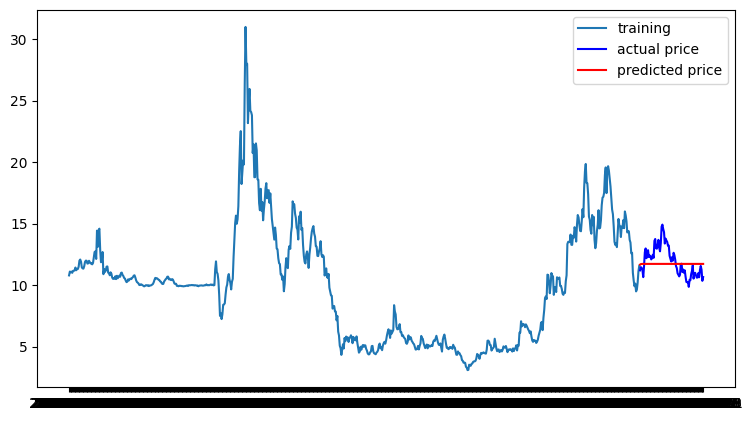

In [142]:
plt.figure(figsize=(9, 5), dpi=100)
plt.plot(np.exp(train_data), label='training')
plt.plot(np.exp(test_data), c='b', label='actual price')
plt.plot(np.exp(fc_series), c='r', label='predicted price')
plt.legend()
plt.show()

In [143]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  1.4709028598339002
MAE:  1.008125747575356
RMSE:  1.2128078412650127
MAPE: 8.28%


(2, 1, 0)이 MAPE값 낮게 나옴

MSE:  1.4709028598339136
MAE:  1.0081257475753567
RMSE:  1.2128078412650183
MAPE: 8.28%

## ARM

In [265]:
import yfinance as yf


cornings = yf.Ticker('ARM')  # '005930.KS'는 삼성전자의 종목 코드입니다. '.KS'는 한국 시장을 의미합니다.



# 데이터 가져오기 (과거부터 오늘까지의 데이터)
cornings_data = cornings.history(period='max')


# 날짜 형식 변경 및 인덱스 설정
cornings_data.index = pd.to_datetime(cornings_data.index).strftime('%Y-%m-%d')

# 데이터프레임 생성
df = pd.DataFrame(cornings_data,  columns=cornings_data.columns)

df


Open        High         Low       Close     Volume  \
Date                                                                    
2023-09-14   56.099998   66.279999   55.540001   63.590000  130534500   
2023-09-15   68.629997   69.000000   60.750000   60.750000   74568900   
2023-09-18   57.950001   58.741001   55.020000   58.000000   34571900   
2023-09-19   56.250000   56.779999   53.880001   55.169998   18308600   
2023-09-20   55.169998   55.400002   51.520000   52.910000   16369500   
...                ...         ...         ...         ...        ...   
2024-02-26  139.000000  149.919998  138.175003  146.199997   26547900   
2024-02-27  144.904999  147.330002  137.000000  137.949997   17481300   
2024-02-28  136.149994  136.289993  131.309998  133.860001    9682600   
2024-02-29  136.279999  141.220001  135.449997  141.039993   10300000   
2024-03-01  141.479996  144.979996  139.039993  141.619995    9805300   

            Dividends  Stock Splits  
Date                                 
2023-09-14        0.0           0.0  
2023-09-15        0.0           0.0  
2023-09-18        0.0           0.0  
2023-09-19        0.0           0.0  
2023-09-20        0.0           0.0  
...               ...           ...  
2024-02-26        0.0           0.0  
2024-02-27        0.0           0.0  
2024-02-28        0.0           0.0  
2024-02-29        0.0           0.0  
2024-03-01        0.0           0.0  

[117 rows x 7 columns]

In [266]:
ts = df['Close']
ts

Date
2023-09-14     63.590000
2023-09-15     60.750000
2023-09-18     58.000000
2023-09-19     55.169998
2023-09-20     52.910000
                 ...    
2024-02-26    146.199997
2024-02-27    137.949997
2024-02-28    133.860001
2024-02-29    141.039993
2024-03-01    141.619995
Name: Close, Length: 117, dtype: float64

In [267]:
ts = ts.interpolate(method='time')
ts[ts.isna()]

ValueError: time-weighted interpolation only works on Series or DataFrames with a DatetimeIndex

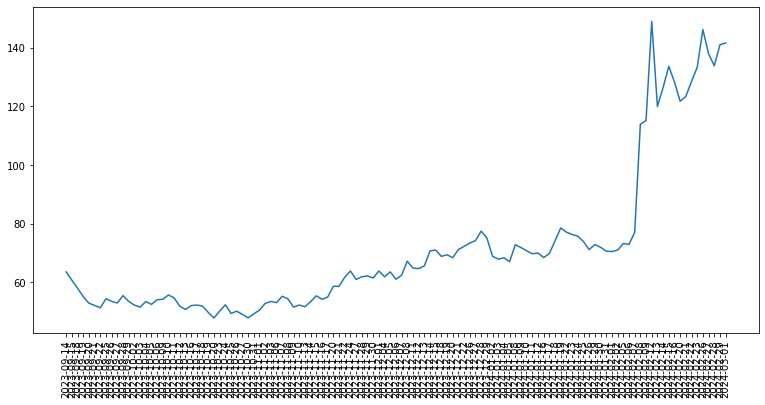

In [268]:
plt.plot(ts)

# x 축 라벨 각도 조정
plt.xticks(rotation=90)

# 그래프 표시
plt.show()

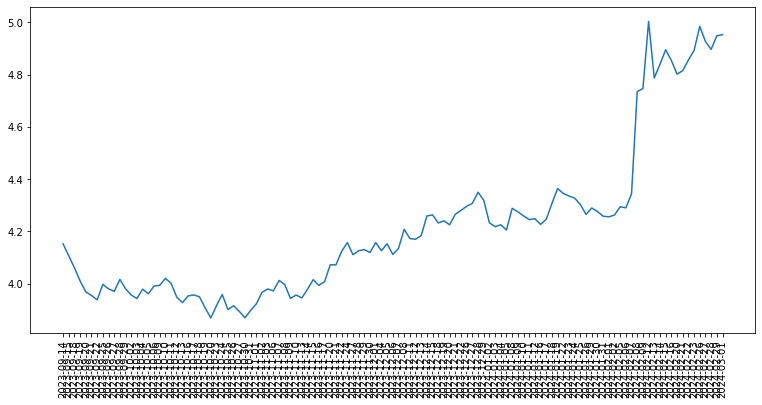

In [269]:
ts_log = np.log(ts)
plt.plot(ts_log)

# x 축 라벨 각도 조정
plt.xticks(rotation=90)

# 그래프 표시
plt.show()

구간 통계치(Rolling Statistics)를 시각화 & 검정을 통해 정상성 확인하기

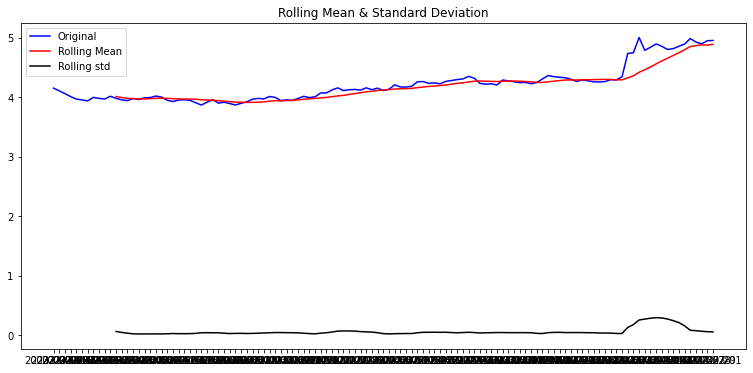

In [270]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

In [271]:
#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)


Results of Dickey=Fuller Test:
Test Statistic                   0.205244
p-value                          0.972554
#Lags Used                       2.000000
Number of Observations Used    114.000000
Critical Value (1%)             -3.489058
Critical Value (5%)             -2.887246
Critical Value (10%)            -2.580481
dtype: float64


계절성 추세 확인하기

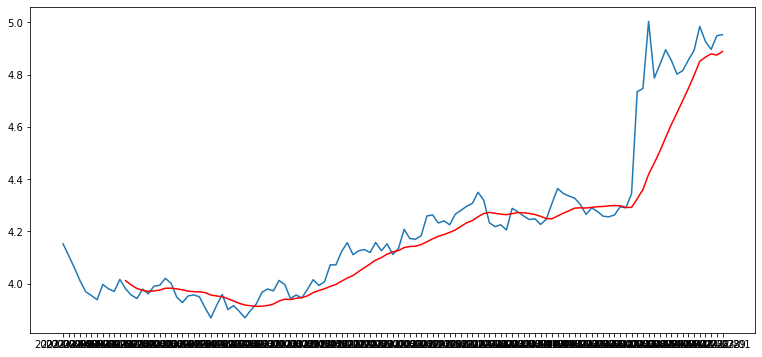

In [272]:
moving_avg = ts_log.rolling(window=12).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [273]:
ts_log_moving_avg = ts_log - moving_avg
ts_log_moving_avg.head(20)

Date
2023-09-14         NaN
2023-09-15         NaN
2023-09-18         NaN
2023-09-19         NaN
2023-09-20         NaN
2023-09-21         NaN
2023-09-22         NaN
2023-09-25         NaN
2023-09-26         NaN
2023-09-27         NaN
2023-09-28         NaN
2023-09-29   -0.031160
2023-10-02   -0.038633
2023-10-03   -0.038271
2023-10-04    0.004515
2023-10-05   -0.009298
2023-10-06    0.018341
2023-10-09    0.018205
2023-10-10    0.037922
2023-10-11    0.018894
Name: Close, dtype: float64

In [274]:
ts_log_moving_avg.dropna(inplace=True)
ts_log_moving_avg.head(20)

Date
2023-09-29   -0.031160
2023-10-02   -0.038633
2023-10-03   -0.038271
2023-10-04    0.004515
2023-10-05   -0.009298
2023-10-06    0.018341
2023-10-09    0.018205
2023-10-10    0.037922
2023-10-11    0.018894
2023-10-12   -0.031608
2023-10-13   -0.048910
2023-10-16   -0.018170
2023-10-17   -0.012401
2023-10-18   -0.019311
2023-10-19   -0.058809
2023-10-20   -0.087926
2023-10-23   -0.036468
2023-10-24    0.008329
2023-10-25   -0.041508
2023-10-26   -0.018122
Name: Close, dtype: float64

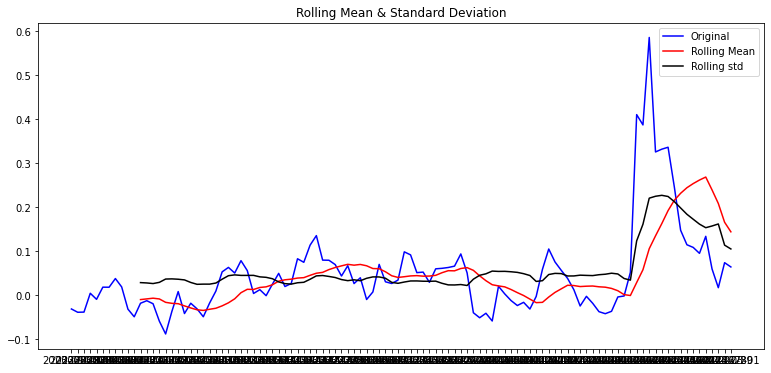

In [275]:
plot_rolling_statistics(ts_log_moving_avg)

In [276]:
augmented_dickey_fuller_test(ts_log_moving_avg)

Results of Dickey=Fuller Test:
Test Statistic                  -3.483708
p-value                          0.008415
#Lags Used                       2.000000
Number of Observations Used    103.000000
Critical Value (1%)             -3.495493
Critical Value (5%)             -2.890037
Critical Value (10%)            -2.581971
dtype: float64


차분(Differencing) - 계절성(Seasonality) 상쇄하기

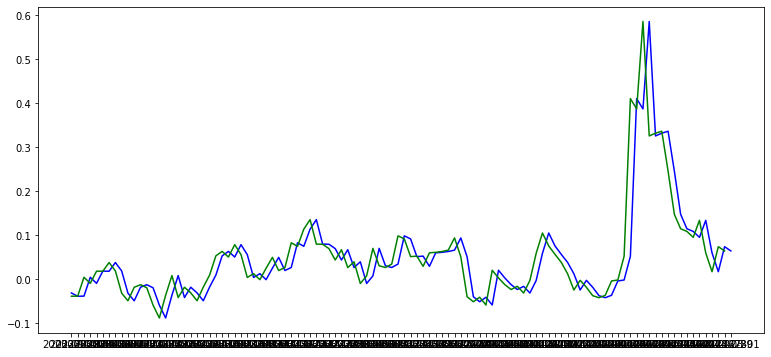

In [277]:
ts_log_moving_avg_shift = ts_log_moving_avg.shift(-1)


plt.plot(ts_log_moving_avg, color='blue')
plt.plot(ts_log_moving_avg_shift, color='green')

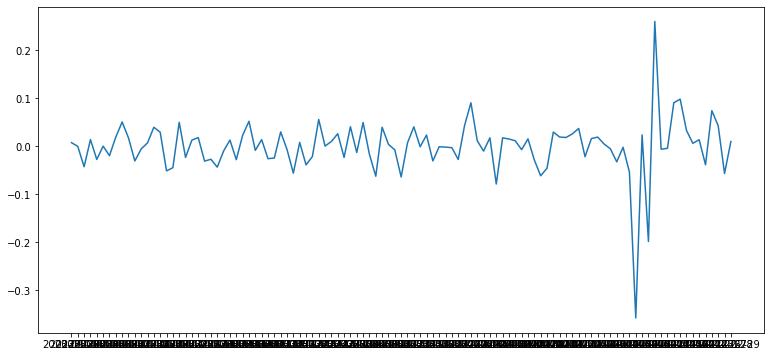

In [278]:
ts_log_moving_avg_diff = ts_log_moving_avg - ts_log_moving_avg_shift
ts_log_moving_avg_diff.dropna(inplace=True)
plt.plot(ts_log_moving_avg_diff)

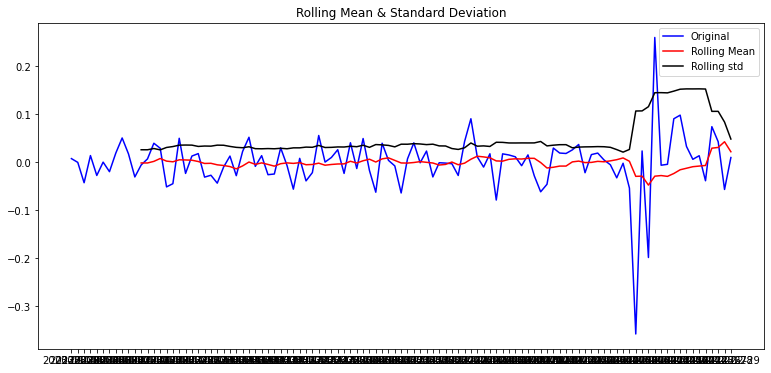

In [279]:
plot_rolling_statistics(ts_log_moving_avg_diff)

In [280]:
augmented_dickey_fuller_test(ts_log_moving_avg_diff)

Results of Dickey=Fuller Test:
Test Statistic                -6.282804e+00
p-value                        3.760431e-08
#Lags Used                     1.000000e+00
Number of Observations Used    1.030000e+02
Critical Value (1%)           -3.495493e+00
Critical Value (5%)           -2.890037e+00
Critical Value (10%)          -2.581971e+00
dtype: float64


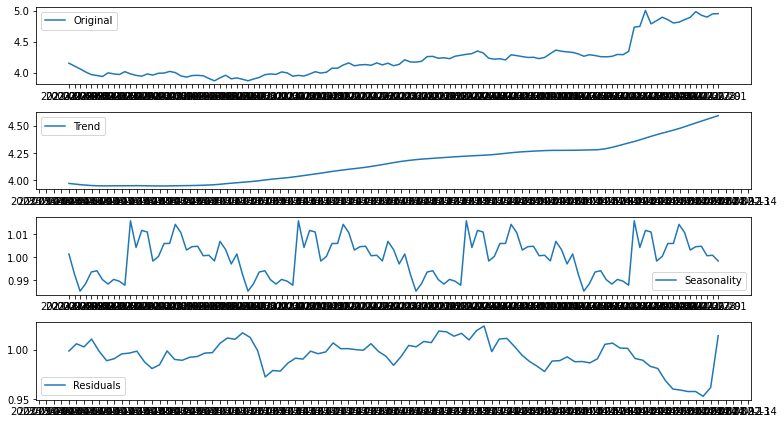

In [281]:
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30)
#시계열 데이터에 0 또는 음수 값이 있어서 발생한 오류이며, 이러한 값은 계절성을 곱하는 방법으로 분해할 수 없음


plt.rcParams['figure.figsize'] = (11,6)


trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

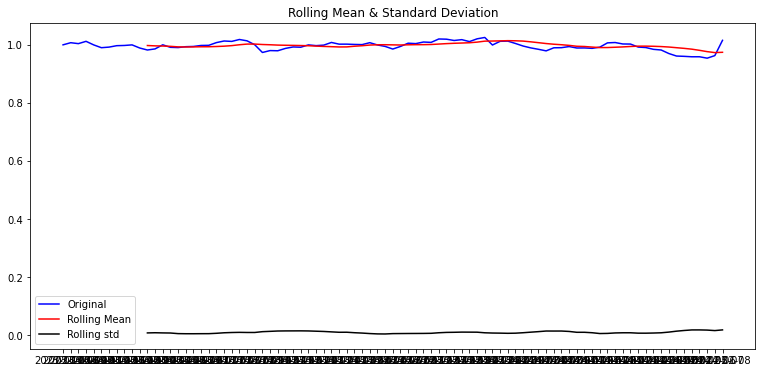

In [282]:
residual.dropna(inplace=True)
plt.rcParams['figure.figsize'] = (13,6)
plot_rolling_statistics(residual)


In [283]:
augmented_dickey_fuller_test(residual)

Results of Dickey=Fuller Test:
Test Statistic                 -3.360215
p-value                         0.012392
#Lags Used                      1.000000
Number of Observations Used    85.000000
Critical Value (1%)            -3.509736
Critical Value (5%)            -2.896195
Critical Value (10%)           -2.585258
dtype: float64


Results of Dickey=Fuller Test:
Test Statistic                -6.659684e+00
p-value                        4.882725e-09
#Lags Used                     1.000000e+00
Number of Observations Used    1.140000e+02
Critical Value (1%)           -3.489058e+00
Critical Value (5%)           -2.887246e+00
Critical Value (10%)          -2.580481e+00
dtype: float64


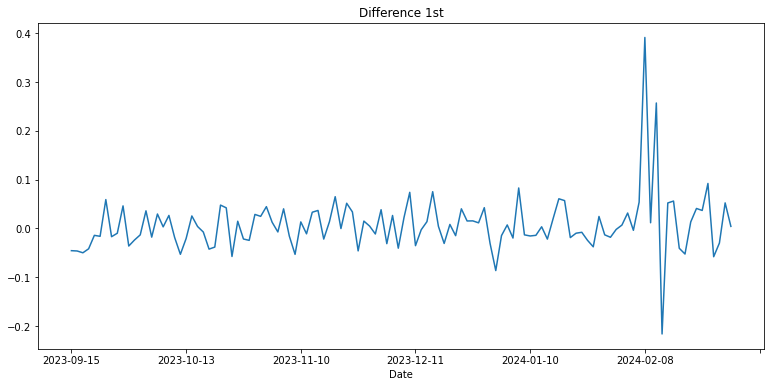

In [284]:
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')
augmented_dickey_fuller_test(diff_1)

Results of Dickey=Fuller Test:
Test Statistic                -6.842400e+00
p-value                        1.777488e-09
#Lags Used                     7.000000e+00
Number of Observations Used    1.070000e+02
Critical Value (1%)           -3.492996e+00
Critical Value (5%)           -2.888955e+00
Critical Value (10%)          -2.581393e+00
dtype: float64


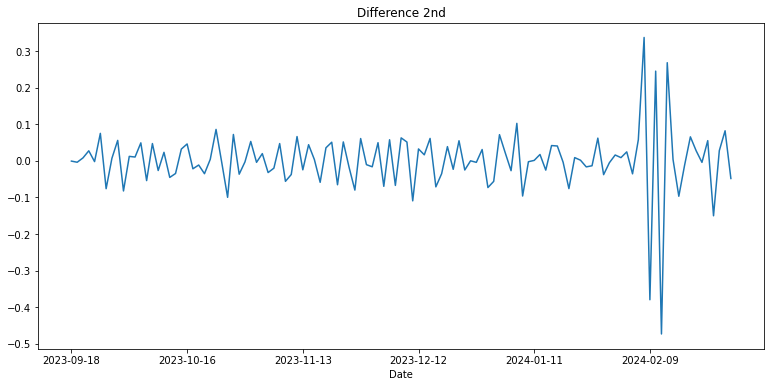

In [285]:
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')
augmented_dickey_fuller_test(diff_2)

<AxesSubplot:title={'center':'Difference 2nd'}, xlabel='Date'>

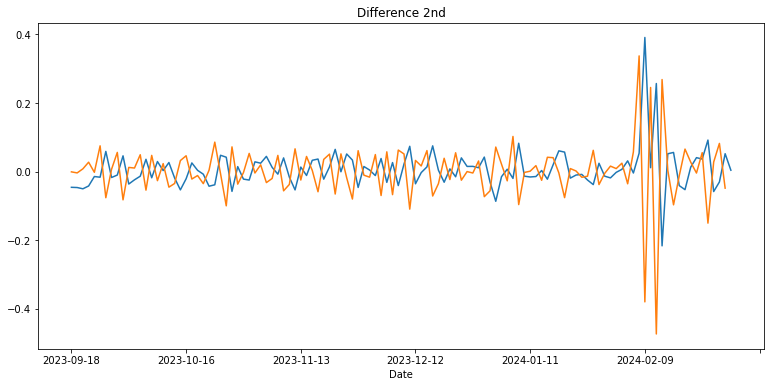

In [286]:
diff_1.plot(title='Difference 1st')
diff_2.plot(title='Difference 2nd')

차분은 1차분으로해도 충분해 보임

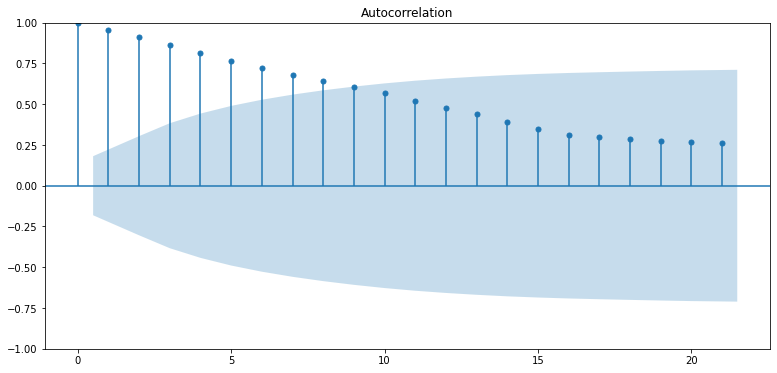

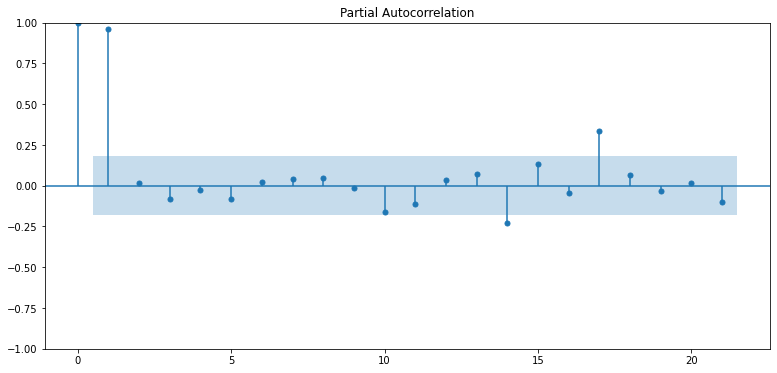

In [287]:
plot_acf(ts_log)
plot_pacf(ts_log)
plt.show()

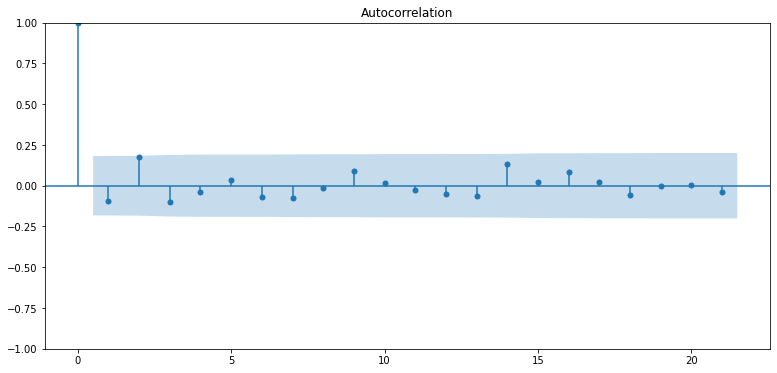

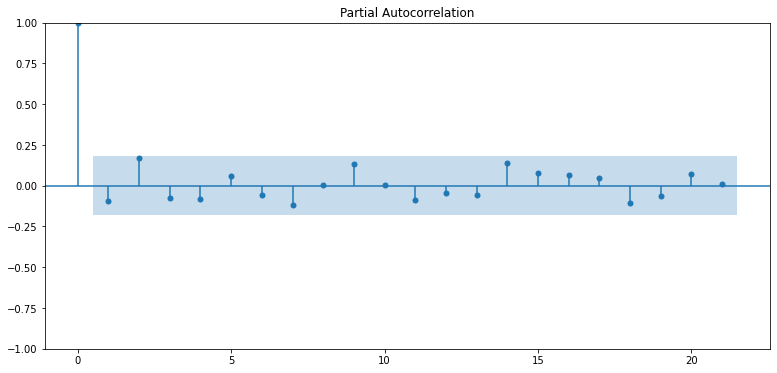

In [288]:
plot_acf(diff_1)
plot_pacf(diff_1)
plt.show()

학습 데이터 분리

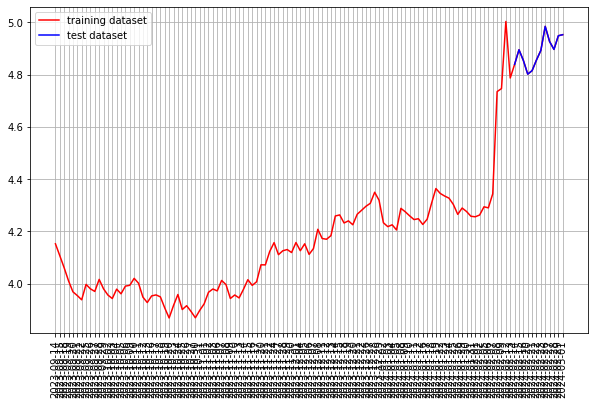

In [289]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]

plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')
plt.plot(test_data, c='b', label='test dataset')
plt.xticks(rotation=90)
plt.legend()

In [290]:
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  105
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 144.485
Date:                Mon, 04 Mar 2024   AIC                           -284.969
Time:                        00:56:15   BIC                           -279.681
Sample:                             0   HQIC                          -282.827
                                - 105                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0698      0.063     -1.104      0.270      -0.194       0.054
sigma2         0.0036      0.000     23.233      0.000       0.003       0.004
Ljung-Box (L1) (Q):                   0.00   Jarque-

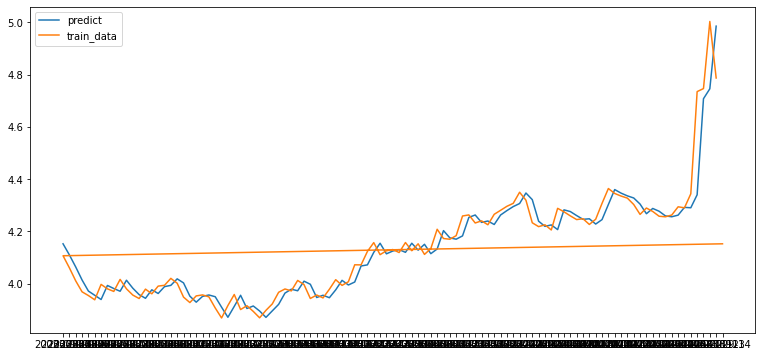

In [291]:
fitted_m = fitted_m.predict()
fitted_m = fitted_m.drop(fitted_m.index[0])
plt.plot(fitted_m, label='predict')
plt.plot(train_data, label='train_data')
plt.legend()

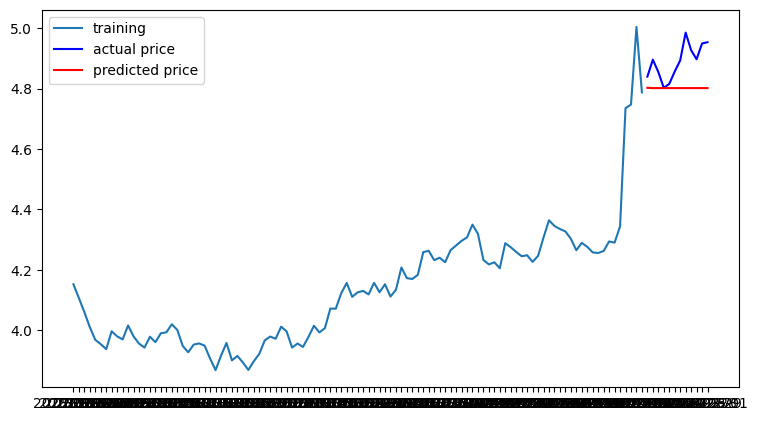

In [292]:
model = ARIMA(train_data, order=(1, 1, 0)) 
fitted_m = model.fit()
fc = fitted_m.forecast(len(test_data), alpha=0.5) # 95% conf
fc = np.array(fc)

fc_series = pd.Series(fc, index=test_data.index)

plt.figure(figsize=(9, 5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r', label='predicted price')
plt.legend()
plt.show()

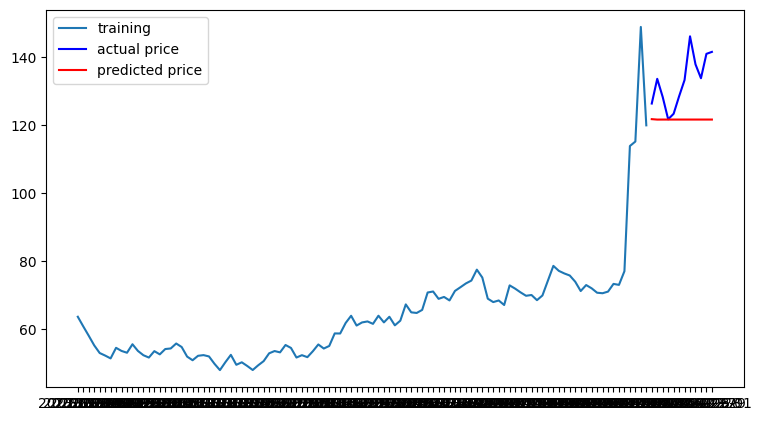

In [293]:
plt.figure(figsize=(9, 5), dpi=100)
plt.plot(np.exp(train_data), label='training')
plt.plot(np.exp(test_data), c='b', label='actual price')
plt.plot(np.exp(fc_series), c='r', label='predicted price')
plt.legend()
plt.show()

In [294]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  181.72298026861418
MAE:  11.314942092002056
RMSE:  13.480466619097953
MAPE: 8.23%


## 쿠팡

In [295]:
import yfinance as yf

cisco = yf.Ticker('CPNG')  



# 데이터 가져오기 (과거부터 오늘까지의 데이터)
cisco_data = cisco.history(period='max')


# 날짜 형식 변경 및 인덱스 설정
cisco_data.index = pd.to_datetime(cisco_data.index).strftime('%Y-%m-%d')

# 데이터프레임 생성
df = pd.DataFrame(cisco_data,  columns=cisco_data.columns)

df


Open       High        Low      Close    Volume  Dividends  \
Date                                                                          
2021-03-11  63.500000  69.000000  49.250000  49.250000  91584100        0.0   
2021-03-12  52.540001  52.759998  46.250000  48.470001  30521000        0.0   
2021-03-15  50.130001  51.849998  49.020000  50.450001  17387800        0.0   
2021-03-16  50.590000  50.770000  46.700001  47.130001  14552400        0.0   
2021-03-17  46.000000  46.900002  43.189999  43.290001  15251100        0.0   
...               ...        ...        ...        ...       ...        ...   
2024-02-26  16.309999  16.400000  15.805000  16.389999  11758700        0.0   
2024-02-27  16.480000  17.250000  16.455000  16.889999  21103300        0.0   
2024-02-28  18.020000  18.299999  17.320000  18.240000  33870400        0.0   
2024-02-29  18.350000  18.950001  18.250000  18.520000  20617500        0.0   
2024-03-01  18.459999  19.055000  18.315001  18.950001  19577400        0.0   

            Stock Splits  
Date                      
2021-03-11           0.0  
2021-03-12           0.0  
2021-03-15           0.0  
2021-03-16           0.0  
2021-03-17           0.0  
...                  ...  
2024-02-26           0.0  
2024-02-27           0.0  
2024-02-28           0.0  
2024-02-29           0.0  
2024-03-01           0.0  

[749 rows x 7 columns]

In [296]:
ts = df['Close']
ts

Date
2021-03-11    49.250000
2021-03-12    48.470001
2021-03-15    50.450001
2021-03-16    47.130001
2021-03-17    43.290001
                ...    
2024-02-26    16.389999
2024-02-27    16.889999
2024-02-28    18.240000
2024-02-29    18.520000
2024-03-01    18.950001
Name: Close, Length: 749, dtype: float64

In [297]:
ts.replace([np.inf, -np.inf], np.nan, inplace=True)

In [298]:
ts.fillna(0, inplace=True)

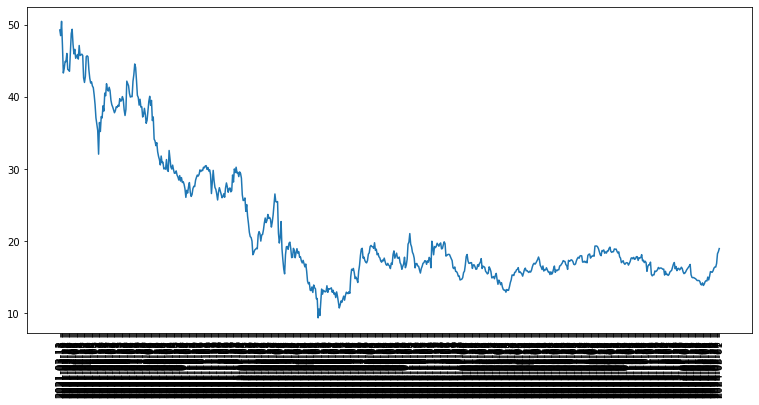

In [299]:
plt.plot(ts)

# x 축 라벨 각도 조정
plt.xticks(rotation=90)

# 그래프 표시
plt.show()

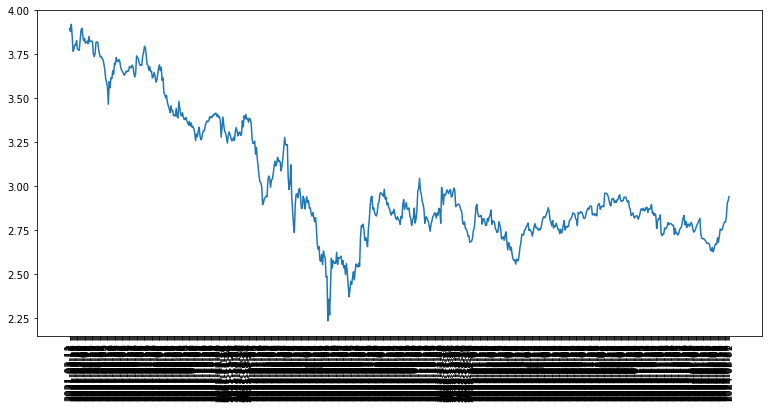

In [300]:
ts_log = np.log(ts)
plt.plot(ts_log)

# x 축 라벨 각도 조정
plt.xticks(rotation=90)

# 그래프 표시
plt.show()

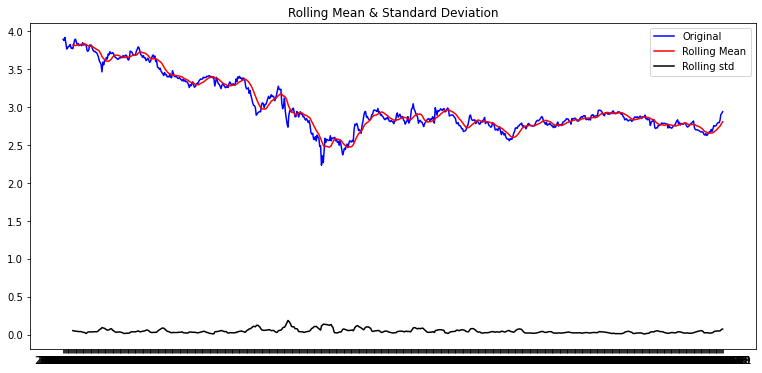

In [301]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

In [302]:
#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

Results of Dickey=Fuller Test:
Test Statistic                  -2.398685
p-value                          0.142108
#Lags Used                       1.000000
Number of Observations Used    747.000000
Critical Value (1%)             -3.439134
Critical Value (5%)             -2.865417
Critical Value (10%)            -2.568834
dtype: float64


계절성 추세 확인하기

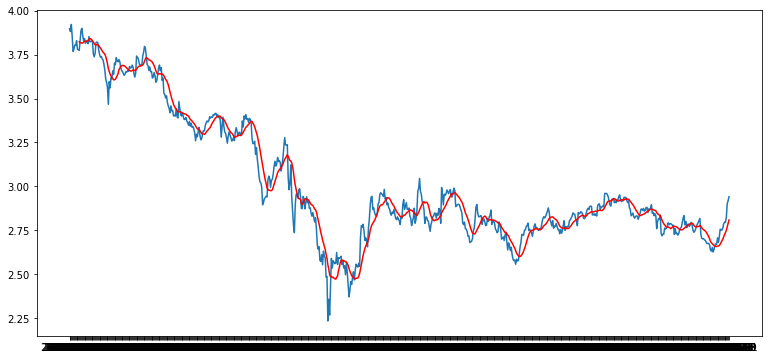

In [303]:
moving_avg = ts_log.rolling(window=12).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [304]:
ts_log_moving_avg = ts_log - moving_avg
ts_log_moving_avg.head(20)

Date
2021-03-11         NaN
2021-03-12         NaN
2021-03-15         NaN
2021-03-16         NaN
2021-03-17         NaN
2021-03-18         NaN
2021-03-19         NaN
2021-03-22         NaN
2021-03-23         NaN
2021-03-24         NaN
2021-03-25         NaN
2021-03-26   -0.048880
2021-03-29    0.012199
2021-03-30    0.069566
2021-03-31    0.083636
2021-04-01    0.041102
2021-04-05    0.006765
2021-04-06    0.015446
2021-04-07   -0.012354
2021-04-08   -0.008181
Name: Close, dtype: float64

In [305]:
ts_log_moving_avg.dropna(inplace=True)
ts_log_moving_avg.head(20)

Date
2021-03-26   -0.048880
2021-03-29    0.012199
2021-03-30    0.069566
2021-03-31    0.083636
2021-04-01    0.041102
2021-04-05    0.006765
2021-04-06    0.015446
2021-04-07   -0.012354
2021-04-08   -0.008181
2021-04-09   -0.002003
2021-04-12   -0.018516
2021-04-13    0.015974
2021-04-14   -0.018055
2021-04-15   -0.015706
2021-04-16   -0.008505
2021-04-19   -0.006068
2021-04-20   -0.067580
2021-04-21   -0.075198
2021-04-22   -0.048605
2021-04-23    0.013232
Name: Close, dtype: float64

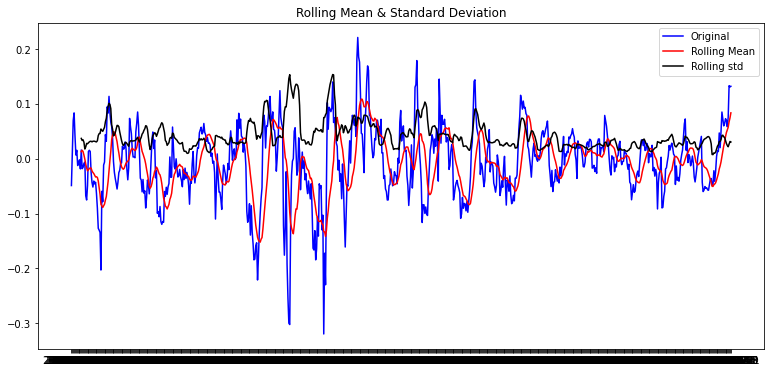

In [306]:
plot_rolling_statistics(ts_log_moving_avg)

In [307]:
augmented_dickey_fuller_test(ts_log_moving_avg)

Results of Dickey=Fuller Test:
Test Statistic                -7.673280e+00
p-value                        1.572874e-11
#Lags Used                     9.000000e+00
Number of Observations Used    7.280000e+02
Critical Value (1%)           -3.439364e+00
Critical Value (5%)           -2.865518e+00
Critical Value (10%)          -2.568888e+00
dtype: float64


차분(Differencing) - 계절성(Seasonality) 상쇄하기

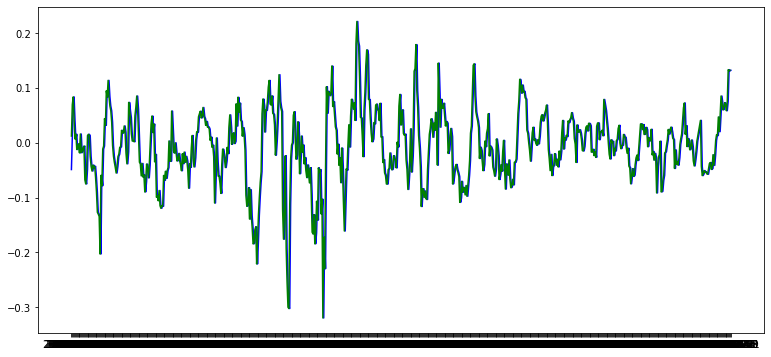

In [308]:
ts_log_moving_avg_shift = ts_log_moving_avg.shift(-1)


plt.plot(ts_log_moving_avg, color='blue')
plt.plot(ts_log_moving_avg_shift, color='green')

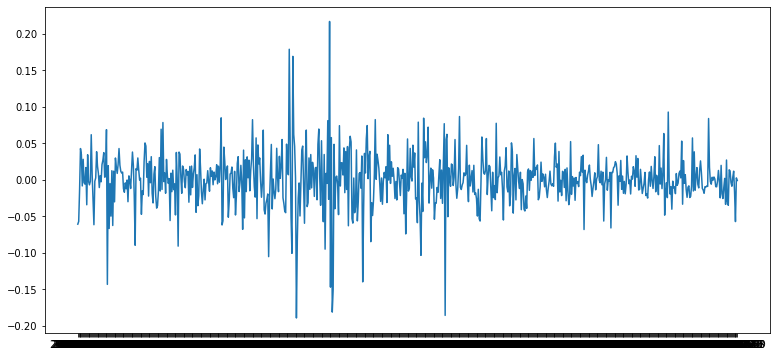

In [309]:
ts_log_moving_avg_diff = ts_log_moving_avg - ts_log_moving_avg_shift
ts_log_moving_avg_diff.dropna(inplace=True)
plt.plot(ts_log_moving_avg_diff)

In [310]:
augmented_dickey_fuller_test(ts_log_moving_avg_diff)

Results of Dickey=Fuller Test:
Test Statistic                -8.776841e+00
p-value                        2.435887e-14
#Lags Used                     1.800000e+01
Number of Observations Used    7.180000e+02
Critical Value (1%)           -3.439490e+00
Critical Value (5%)           -2.865574e+00
Critical Value (10%)          -2.568918e+00
dtype: float64


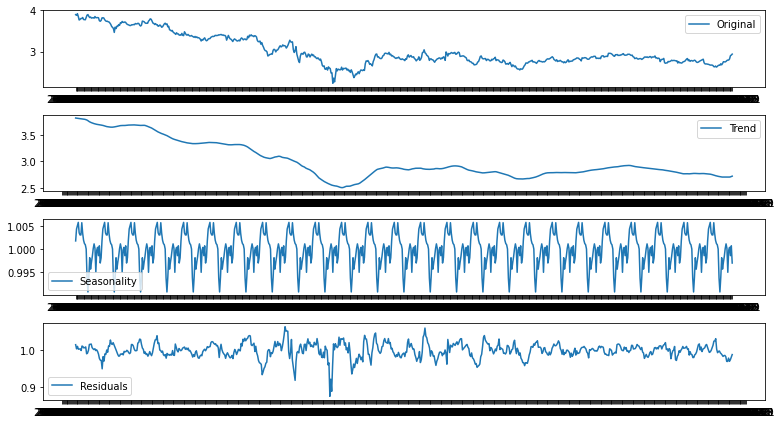

In [311]:
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 


plt.rcParams['figure.figsize'] = (11,6)


trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

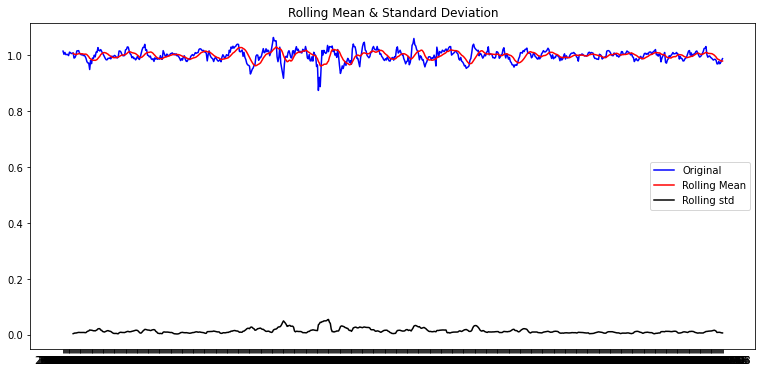

In [312]:
residual.dropna(inplace=True)
plt.rcParams['figure.figsize'] = (13,6)
plot_rolling_statistics(residual)

In [313]:
augmented_dickey_fuller_test(residual)

Results of Dickey=Fuller Test:
Test Statistic                -8.942152e+00
p-value                        9.191534e-15
#Lags Used                     1.800000e+01
Number of Observations Used    7.000000e+02
Critical Value (1%)           -3.439726e+00
Critical Value (5%)           -2.865678e+00
Critical Value (10%)          -2.568973e+00
dtype: float64


Results of Dickey=Fuller Test:
Test Statistic                 -28.767198
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    747.000000
Critical Value (1%)             -3.439134
Critical Value (5%)             -2.865417
Critical Value (10%)            -2.568834
dtype: float64


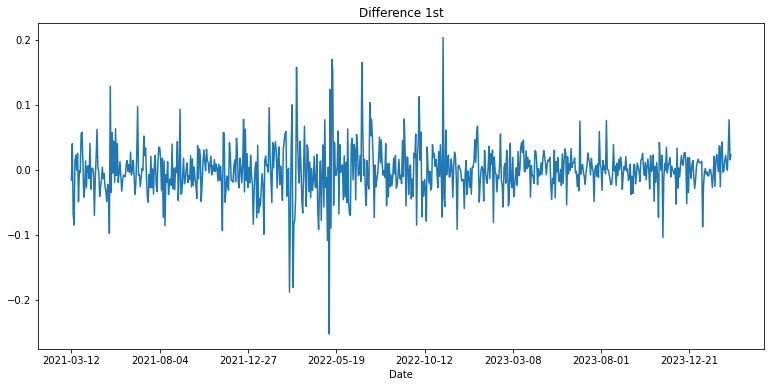

In [314]:
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')
augmented_dickey_fuller_test(diff_1)

Results of Dickey=Fuller Test:
Test Statistic                -1.152771e+01
p-value                        3.899466e-21
#Lags Used                     1.600000e+01
Number of Observations Used    7.300000e+02
Critical Value (1%)           -3.439340e+00
Critical Value (5%)           -2.865507e+00
Critical Value (10%)          -2.568883e+00
dtype: float64


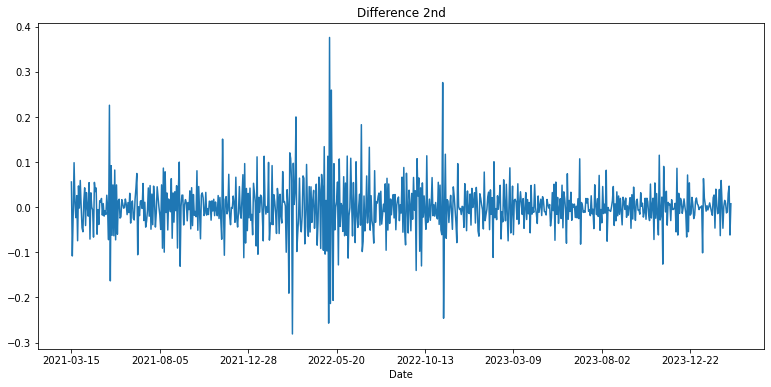

In [315]:
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

<AxesSubplot:title={'center':'Difference 2nd'}, xlabel='Date'>

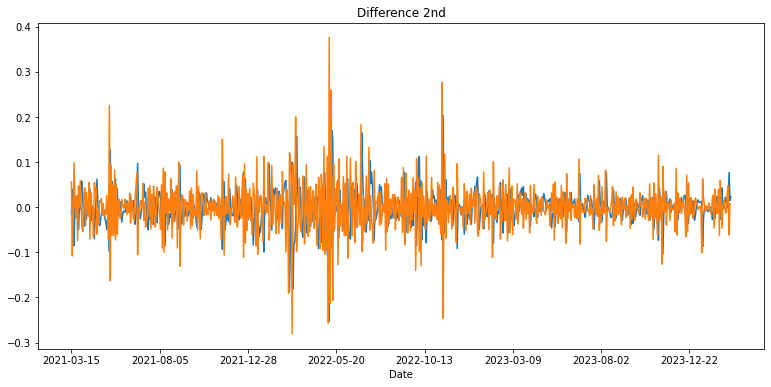

In [316]:
diff_1.plot(title='Difference 1st')
diff_2.plot(title='Difference 2nd')

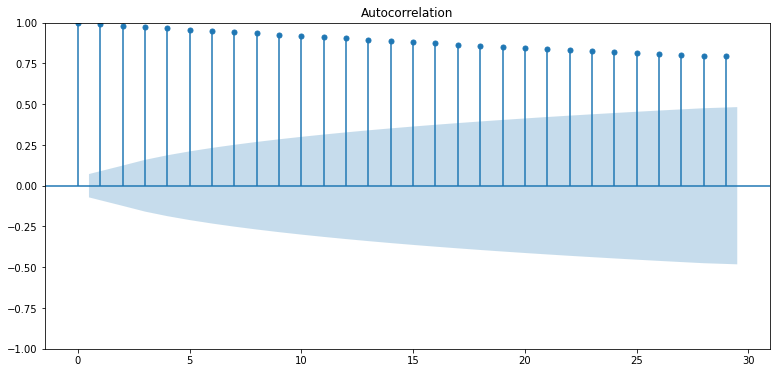

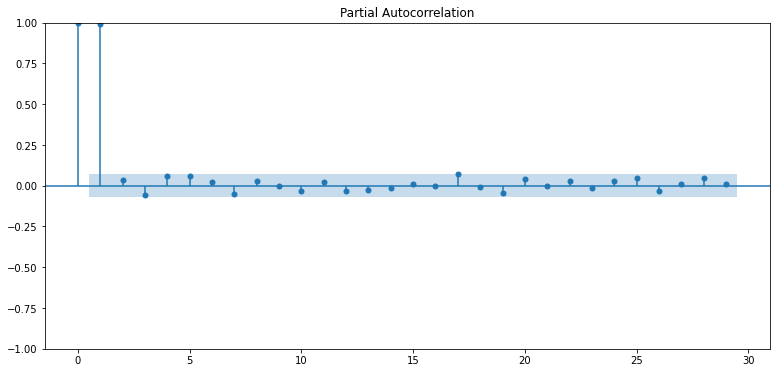

In [317]:
plot_acf(ts_log)
plot_pacf(ts_log)
plt.show()

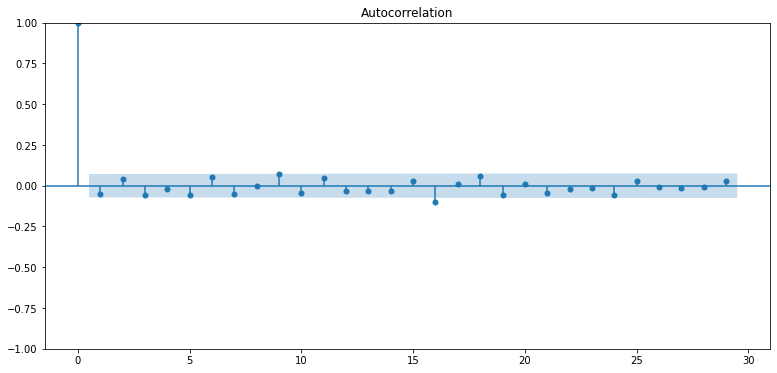

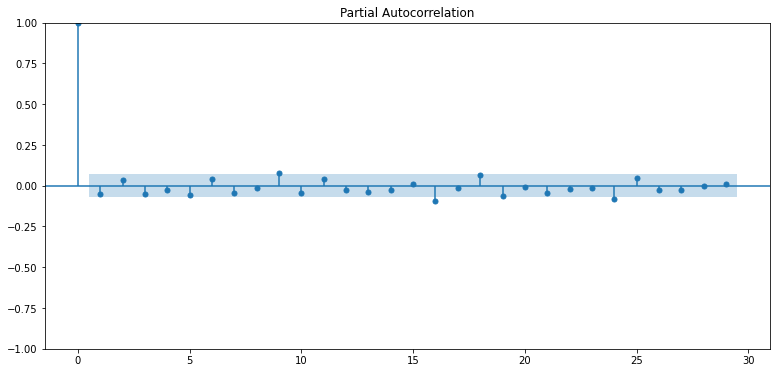

In [318]:
plot_acf(diff_1)
plot_pacf(diff_1)
plt.show()

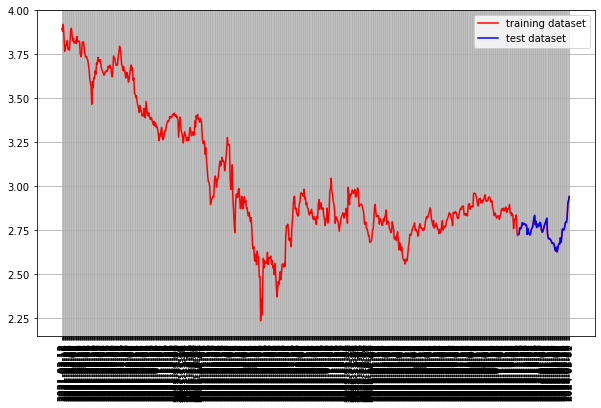

In [319]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]

plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')
plt.plot(test_data, c='b', label='test dataset')
plt.xticks(rotation=90)
plt.legend()

In [320]:
model = ARIMA(train_data, order=(0, 1, 12))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  674
Model:                ARIMA(0, 1, 12)   Log Likelihood                1228.827
Date:                Mon, 04 Mar 2024   AIC                          -2431.653
Time:                        00:58:32   BIC                          -2373.001
Sample:                             0   HQIC                         -2408.939
                                - 674                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0467      0.026     -1.819      0.069      -0.097       0.004
ma.L2          0.0280      0.033      0.846      0.398      -0.037       0.093
ma.L3         -0.0563      0.028     -2.017      0.0

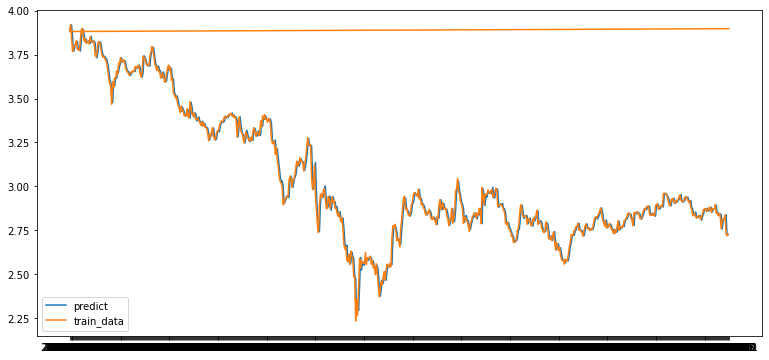

In [321]:
fitted_m = fitted_m.predict()
fitted_m = fitted_m.drop(fitted_m.index[0])
plt.plot(fitted_m, label='predict')
plt.plot(train_data, label='train_data')
plt.legend()

ma값을 넣어서 진행
p*q = 0 으로 진행

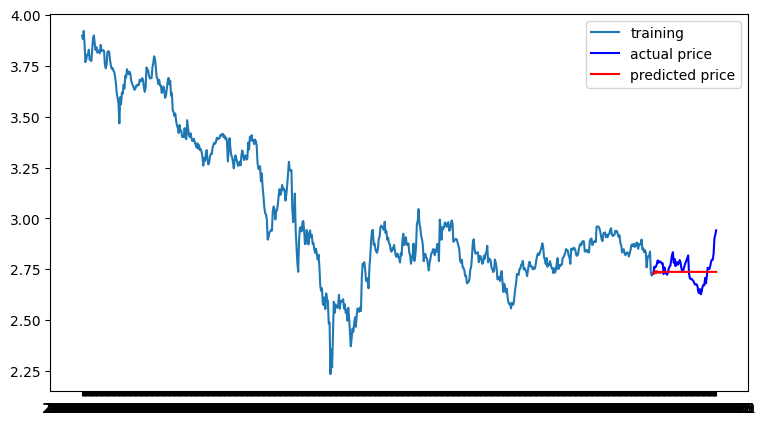

In [322]:
model = ARIMA(train_data, order=(0, 1, 12))  
fitted_m = model.fit()
fc = fitted_m.forecast(len(test_data), alpha=0.5) # 95% conf
fc = np.array(fc)

fc_series = pd.Series(fc, index=test_data.index)

plt.figure(figsize=(9, 5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r', label='predicted price')
plt.legend()
plt.show()

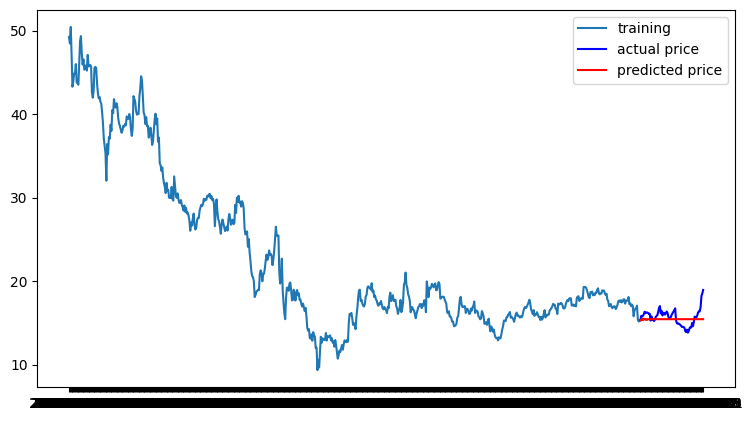

In [323]:
plt.figure(figsize=(9, 5), dpi=100)
plt.plot(np.exp(train_data), label='training')
plt.plot(np.exp(test_data), c='b', label='actual price')
plt.plot(np.exp(fc_series), c='r', label='predicted price')
plt.legend()
plt.show()

In [324]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  1.0062569850481202
MAE:  0.787837647195474
RMSE:  1.0031236140417192
MAPE: 4.96%


### 회고

- 야후 파이낸스에서 제공하는 데이터를 최대치를 넣어 모델을 테스트 해보니 흥미로웠습니다.
- 하지만 p, q 적절한 값을 찾기에는 어려움이 많았습니다.
- 시계열에 대해서 많은 공부가 필요하다는 것을 느꼈습니다.
- 예측, 학습 데이터에 대한 그래프를 그리는데 학습데이터 값에서 횡방향으로 그어지는 문제가 발생했는데
해결을 하지 못해서 조금 아쉽습니다.
- 더 다양한 데이터와 함께 학습을 한다면 조금 달라질 수 있겠지만, 주가를 예측하는 것은 어려워보인다
